# 0.0 SET UP

## 0.1 Libraries

In [1]:
import pandas as pd
import inflection
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from boruta                         import BorutaPy
from pandas import DataFrame
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve

## 0.2 Helper Functions

In [2]:


def rename_columns(df1):
    # original columns names
    cols_old = df1.columns
    
    # applying snakecase type to columns names
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))

    # renamed columns
    df1.columns = cols_new
    
    return df1

def num_statistics (num_attributes):

    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    
    # Central Tendency - mean, median

    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Dispersion - std, min, max, range, skew, kurtosis

    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    
    
    ## concatenate

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    
    m.columns = ['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kutosis']

    return m

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 ,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

# Logistic Regression Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

## 0.3 Loading Data

In [3]:
data_raw = pd.read_csv('data/churn.csv')

## 0.4 Settings

In [4]:

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'seaborn' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()


Populating the interactive namespace from numpy and matplotlib


# STEP 01 - DATA DESCRIPTION

## 1.1 Dataset


In [5]:
df1 = data_raw.copy()

In [6]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.2 Rename Columns

In [7]:
rename_columns(df1)
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.3 Data Dimension

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 1.4 Descriptive Statistic

### 1.4.1 Numerical Attributes

In [9]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [10]:
num_statistics (num_attributes)


,attibutes,min,max,range,mean,median,std,skew,kutosis
0,row_number,1.00000,10000.00000,9999.00000,5000.50000,5000.50000,2886.75133,0.00000,-1.20000
1,customer_id,15565701.00000,15815690.00000,249989.00000,15690940.56940,15690738.00000,71932.58922,0.00115,-1.19611
2,credit_score,350.00000,850.00000,500.00000,650.52880,652.00000,96.64847,-0.07161,-0.42573
3,age,18.00000,92.00000,74.00000,38.92180,37.00000,10.48728,1.01132,1.39535
4,tenure,0.00000,10.00000,10.00000,5.01280,5.00000,2.89203,0.01099,-1.16523
5,balance,0.00000,250898.09000,250898.09000,76485.88929,97198.54000,62394.28525,-0.14111,-1.48941
6,num_of_products,1.00000,4.00000,3.00000,1.53020,1.00000,0.58163,0.74557,0.58298
7,has_cr_card,0.00000,1.00000,1.00000,0.70550,1.00000,0.45582,-0.90181,-1.18697
8,is_active_member,0.00000,1.00000,1.00000,0.51510,1.00000,0.49977,-0.06044,-1.99675
9,estimated_salary,11.58000,199992.48000,199980.90000,100090.23988,100193.91500,57507.61722,0.00209,-1.18152


### 1.4.2 Categorical Attributes

In [11]:
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

In [12]:
cat_attributes.apply(lambda x: x.unique().shape[0])


surname      2932
geography       3
gender          2
dtype: int64

In [13]:
cat_attributes.describe()

,surname,geography,gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [14]:
cat_attributes['surname'].value_counts().reset_index()

,index,surname
0,Smith,32
1,Martin,29
2,Scott,29
3,Walker,28
4,Brown,26
5,Shih,25
6,Yeh,25
7,Genovese,25
8,Wright,24
9,Maclean,24


In [15]:
cat_attributes['geography'].value_counts().reset_index()

,index,geography
0,France,5014
1,Germany,2509
2,Spain,2477


In [16]:
cat_attributes['gender'].value_counts().reset_index()

,index,gender
0,Male,5457
1,Female,4543


# STEP 02 - FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1 Mind Map

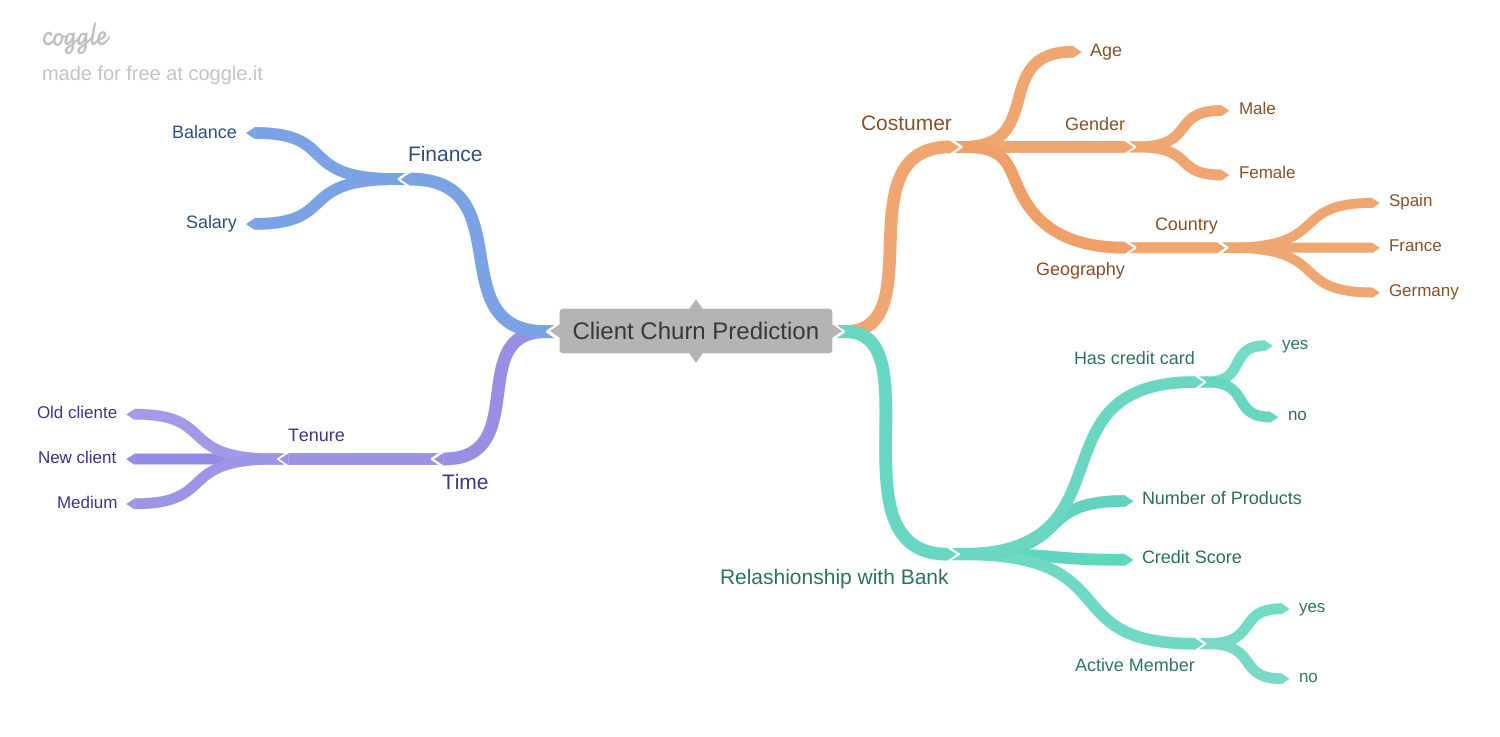

In [18]:
Image('img/Client_Churn_Prediction.png')

## 2.2 Hypothesis List

### 2.2.1 Hypothesis - Finance

**1** Costumers with lower salary tend have high churn rate than costumers with higher salaries.

**2** Costumers with low balance tend have high churn rate than costumers with high balance.

### 2.2.2 Hypothesis - Time

**1** Newer costumers tend to have higher churn rates than the old ones.

### 2.2.3 Hypothesis - Costumer

**1** Young costumers have higher churn rate than the old ones.

**2** Female costumers have higher churn rates than male costumers.

**3** Churn rate are higher in costumers from France than from Spain and Germany.

### 2.2.4 Hypothesis - Relashionship with Bank

**1** Costumers with no credit card have higher churn rate than the ones that have.

**2** Costumers that use one product from the bank have higher churn rate.

**3** Costumers with low credit score have higher churn rate than the ones with high score.

**4** Costumers that are not active members have higher churn rate.

### 2.2.5 - Hypothesis - Final List 

**H1.** Costumers with lower salary tend have high churn rate than costumers with higher salaries.

**H2.** Costumers with low balance tend have high churn rate than costumers with high balance.

**H3.** Newer costumers tend to have higher churn rates than the old ones.

**H4.** Young costumers have higher churn rate than the old ones. 

**H5.** Female costumers have higher churn rates than male costumers.

**H6.** Churn rate are higher in costumers from France than from Spain and Germany.

**H7.** Costumers with no credit card have higher churn rate than the ones that have.

**H8.** Costumers that use one product from the bank have higher churn rate.

**H9.** Costumers with low credit score have higher churn rate than the ones with high score.

**H10.** Costumers that are not active members have higher churn rate.

## 2.3 Feature Engineering

# STEP 03 - DATA FILTERING

# STEP 04 - EXPLORATORY DATA ANALYSIS

In [19]:
df4 = df2.copy()

## 4.1 Response Variable

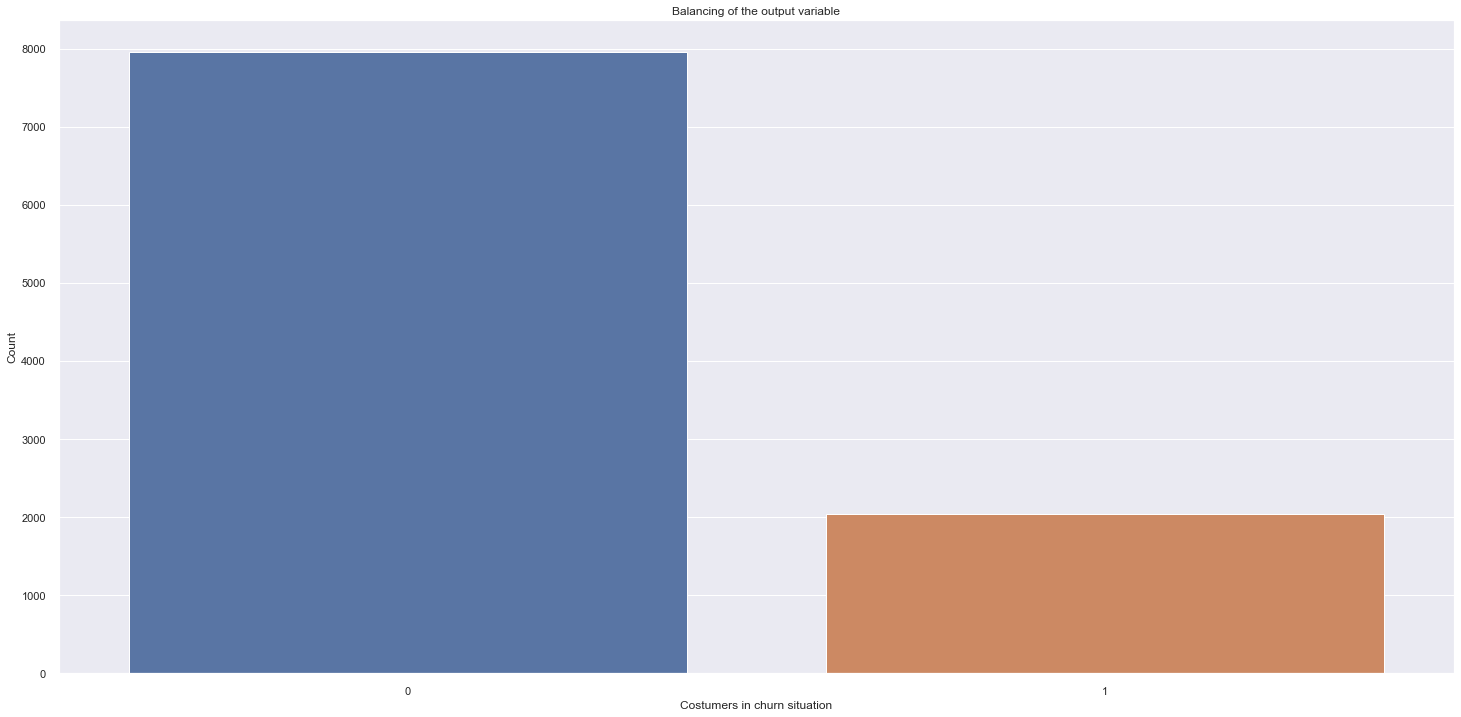

In [20]:
# Plot of the output variable - 'Exited'
sns.countplot(x=df4['exited'])

## settings of the plot
plt.title("Balancing of the output variable");
plt.xlabel("Costumers in churn situation");
plt.ylabel("Count");


In [21]:
df4['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [22]:
exited_total = df4['exited'].shape[0]
exited_churn = df4[df4['exited'] == 1].shape[0]
exited_perc_churn = (exited_churn/exited_total)*100

print('Percentage of costumers in churn is {0:.2f}%'.format(exited_perc_churn))

Percentage of costumers in churn is 20.37%


## 4.2 Univariate Analysis 

### 4.2.1 Numerical Variables

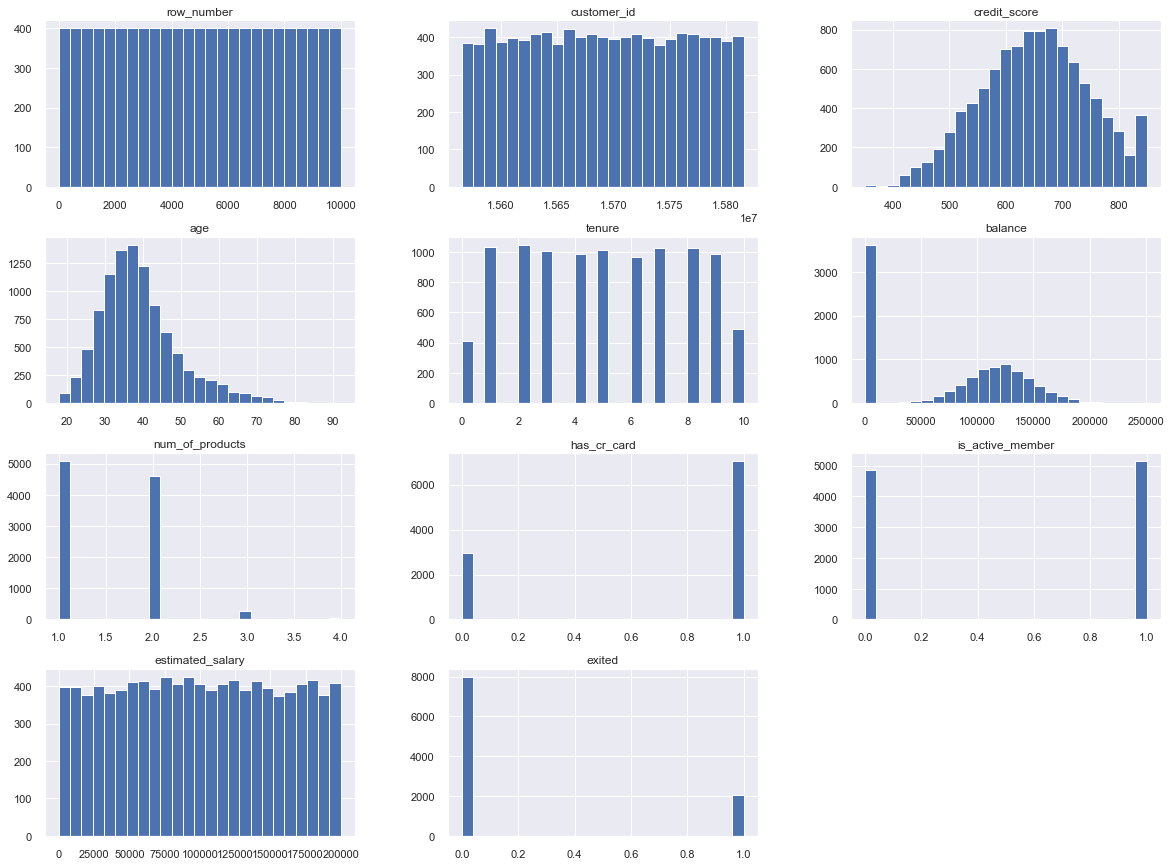

In [23]:
num_hist = num_attributes.hist( bins=25, figsize=(20,15) )

### 4.2.2 Categorical Variables

<AxesSubplot:xlabel='geography', ylabel='count'>

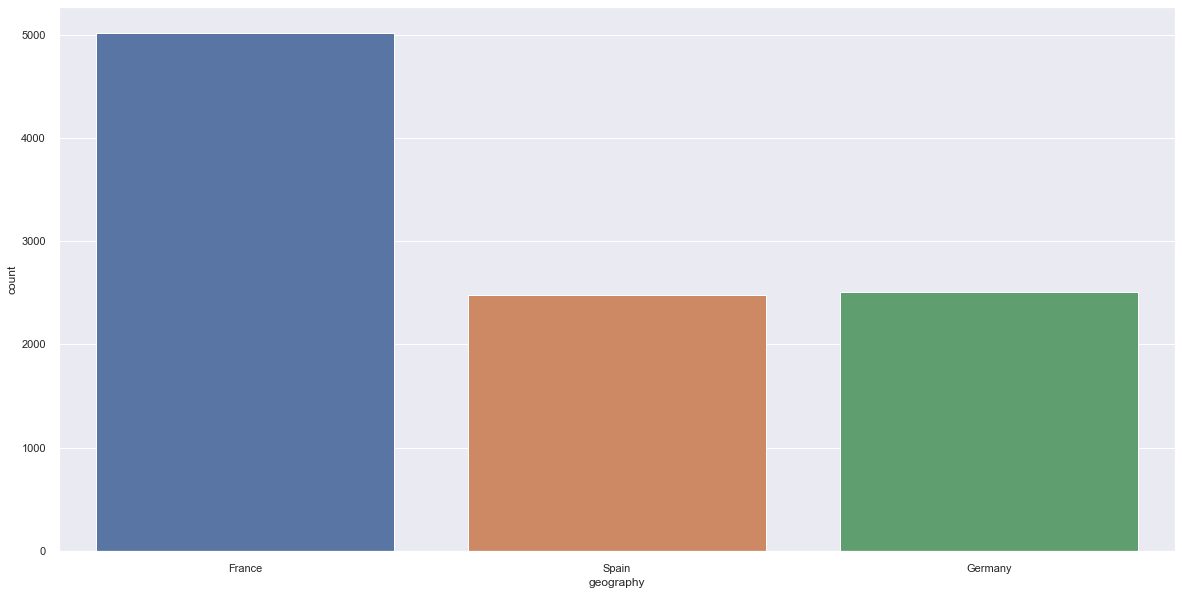

In [24]:
# Plot - 'Geography'
plt.figure(figsize=(20,10))
sns.countplot(x=df4['geography'])


In [25]:
# Percentage distribution of geography

df4['geography'].value_counts(normalize=True).reset_index()


,index,geography
0,France,0.50140
1,Germany,0.25090
2,Spain,0.24770


<AxesSubplot:xlabel='gender', ylabel='count'>

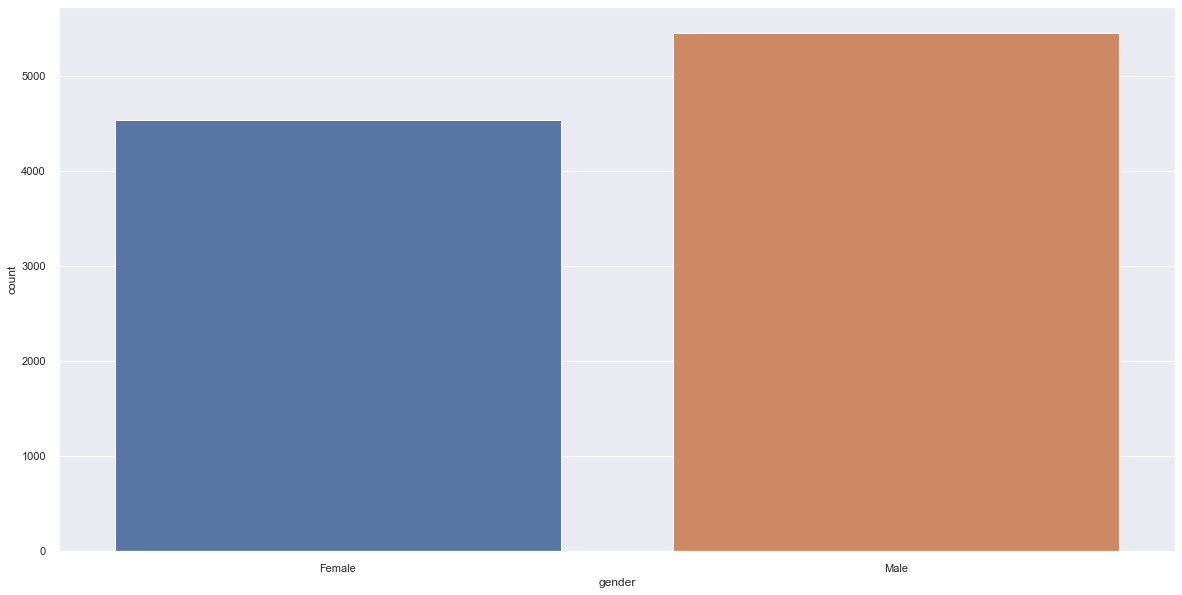

In [26]:
# Plot - 'Gender'
plt.figure(figsize=(20,10))
sns.countplot(x=df4['gender'])


In [27]:
# Percentage distribution of gender

df4['gender'].value_counts(normalize=True).reset_index()


,index,gender
0,Male,0.54570
1,Female,0.45430


## 4.3 Bivariate Analysis

In [28]:
aux_churn = df4[df4['exited'] == 1]
aux_nochurn = df4[df4['exited'] == 0]

### H1. Costumers with lower salary tend have high churn rate than costumers with higher salaries.

**Response:** FALSE

High salary -> CHURN

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


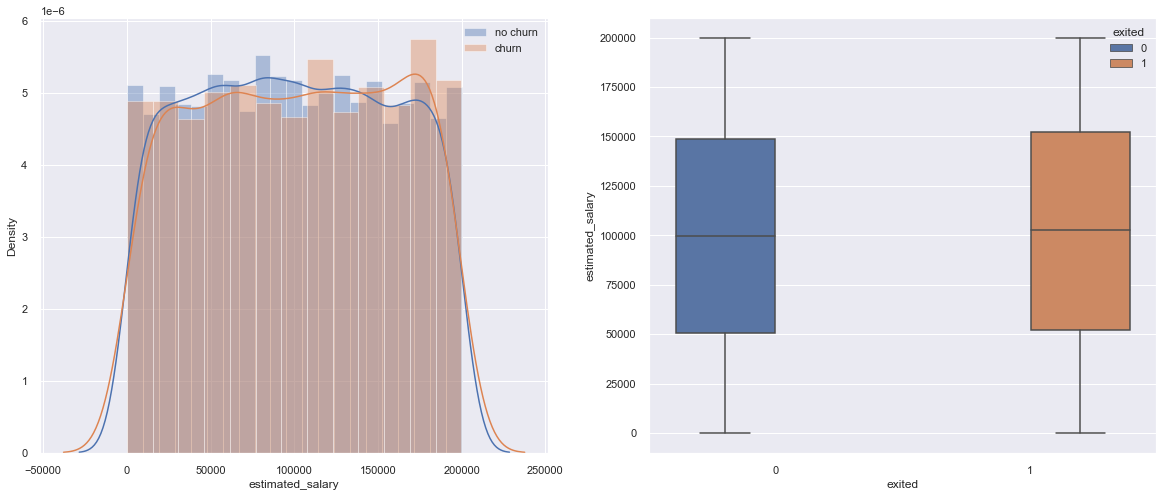

In [29]:


# Plot of estimated salary vs churn situation

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(aux_nochurn['estimated_salary'], kde=True, label='no churn')
sns.distplot(aux_churn['estimated_salary'], kde=True, label='churn')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot(x='exited', y='estimated_salary', hue='exited', data=df4);

<ipython-input-30-748aa8275893>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_churn['estimated_salary_binned'] = pd.cut(aux_churn['estimated_salary'], bins=bins)
<ipython-input-30-748aa8275893>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_nochurn['estimated_salary_binned'] = pd.cut(aux_nochurn['estimated_salary'], bins=bins)


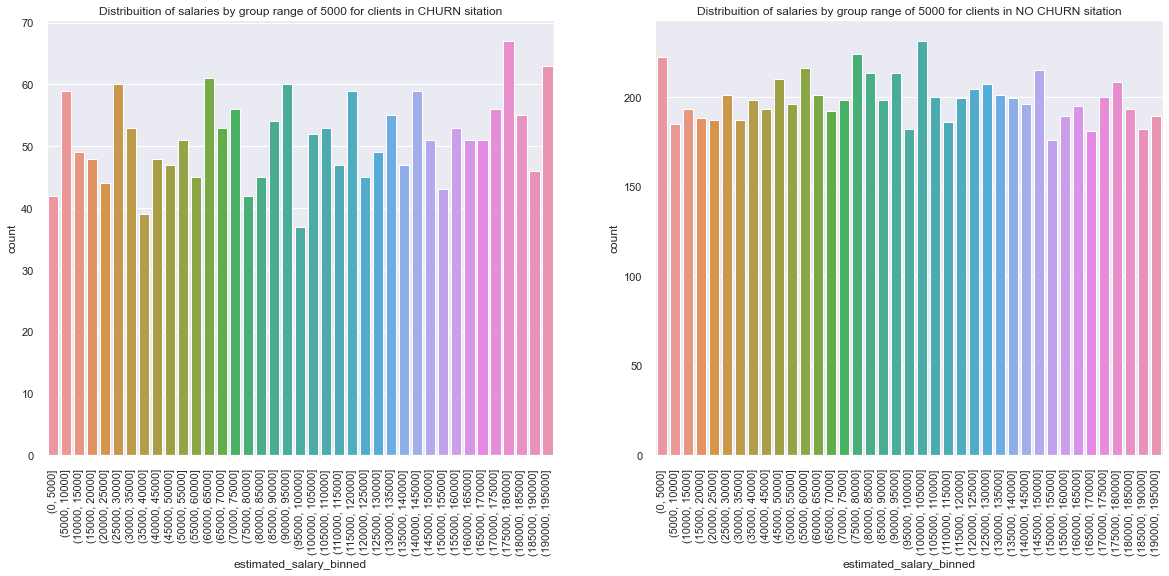

In [30]:
plt.figure(figsize=(20,8))

# Distribuition of salaries by group range of 5.000 for clients in CHURN sitation

plt.subplot(1,2,1)

# settings
bins = list (np.arange(0, 200000, 5000))
aux_churn['estimated_salary_binned'] = pd.cut(aux_churn['estimated_salary'], bins=bins)

# Plot 
sns.countplot(x=aux_churn['estimated_salary_binned'])
plt.xticks(rotation='90');
plt.title('Distribuition of salaries by group range of 5000 for clients in CHURN sitation');

plt.subplot(1,2,2)
# Distribuition of salaries by group range of 5000 for clients in NO CHURN sitation

# settings
bins = list (np.arange(0, 200000, 5000))
aux_nochurn['estimated_salary_binned'] = pd.cut(aux_nochurn['estimated_salary'], bins=bins)

# Plot 
sns.countplot(x=aux_nochurn['estimated_salary_binned'])
plt.xticks(rotation='90');
plt.title('Distribuition of salaries by group range of 5000 for clients in NO CHURN sitation');

<ipython-input-31-d75049d0f1d7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_es['estimated_salary_binned'] = pd.cut(aux_es['estimated_salary'], bins=bins)


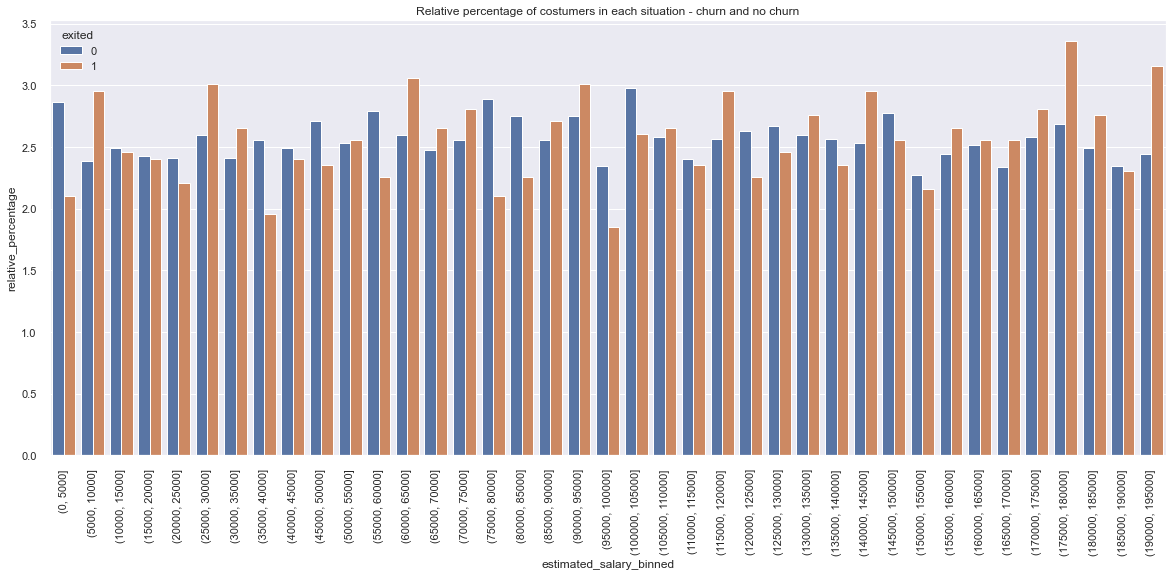

In [31]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_es = df4[['estimated_salary', 'exited']]

# grouping the dataframe in bins of 5000 of salary
bins = list (np.arange(0, 200000, 5000))
aux_es['estimated_salary_binned'] = pd.cut(aux_es['estimated_salary'], bins=bins)
aux_es_grouped = aux_es[['estimated_salary_binned', 'exited', 'estimated_salary']].groupby(['estimated_salary_binned', 'exited']).count().reset_index()

# renaming columns
aux_es_grouped.columns = ['estimated_salary_binned', 'exited', 'number_costumers']

# finding the total count for each situation - churn and no churn
es_churn = aux_es_grouped[aux_es_grouped['exited'] == 1]['number_costumers'].sum()
es_nochurn = aux_es_grouped[aux_es_grouped['exited'] == 0]['number_costumers'].sum()


# calculating relative percentage of costumers in each situation - churn and no churn
aux_es_grouped['relative_percentage'] = aux_es_grouped.apply(lambda x: ((x['number_costumers']/es_churn)*100) if x['exited'] == 1 else ((x['number_costumers']/es_nochurn)*100), axis=1)

aux_es_grouped

# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='estimated_salary_binned', y='relative_percentage', hue='exited', data=aux_es_grouped)
plt.xticks(rotation=90);
plt.title('Relative percentage of costumers in each situation - churn and no churn');


### H2. Costumers with low balance tend have high churn rate than costumers with high balance.

**Response:** FALSE

High balance -> CHURN

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


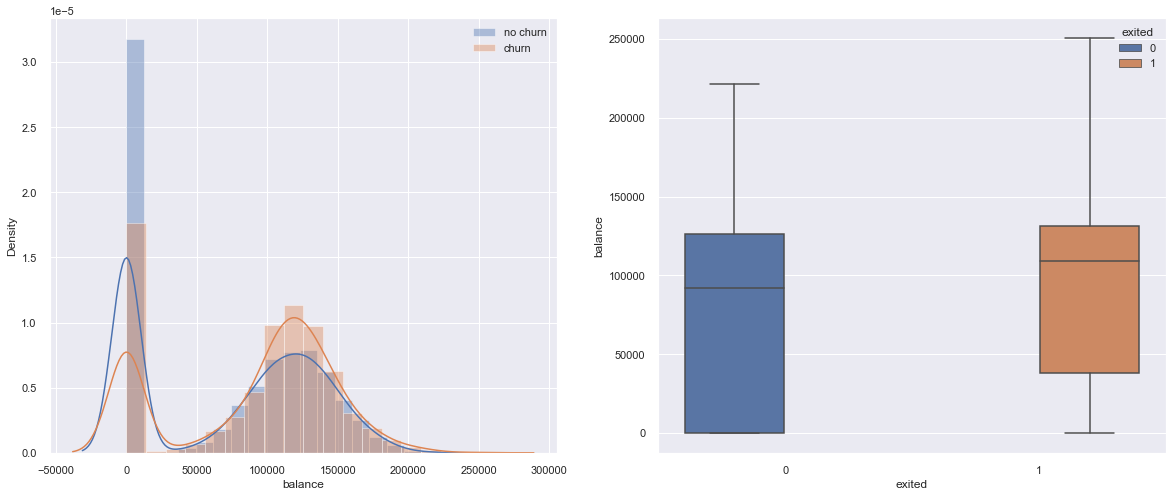

In [32]:
# Plot of balance vs churn situation

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(aux_nochurn['balance'], kde=True, label='no churn')
sns.distplot(aux_churn['balance'], kde=True, label='churn')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot(x='exited', y='balance', hue='exited', data=df4);

In [33]:
aux_churn['balance'].describe()

count     2037.00000
mean     91108.53934
std      58360.79482
min          0.00000
25%      38340.02000
50%     109349.29000
75%     131433.33000
max     250898.09000
Name: balance, dtype: float64

In [34]:
aux_nochurn['balance'].describe()

count     7963.00000
mean     72745.29678
std      62848.04070
min          0.00000
25%          0.00000
50%      92072.68000
75%     126410.28000
max     221532.80000
Name: balance, dtype: float64

<ipython-input-35-d9a27e39ca36>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_churn['balance_binned'] = pd.cut(aux_churn['balance'], bins=bins1)
<ipython-input-35-d9a27e39ca36>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_nochurn['balance_binned'] = pd.cut(aux_nochurn['balance'], bins=bins1)


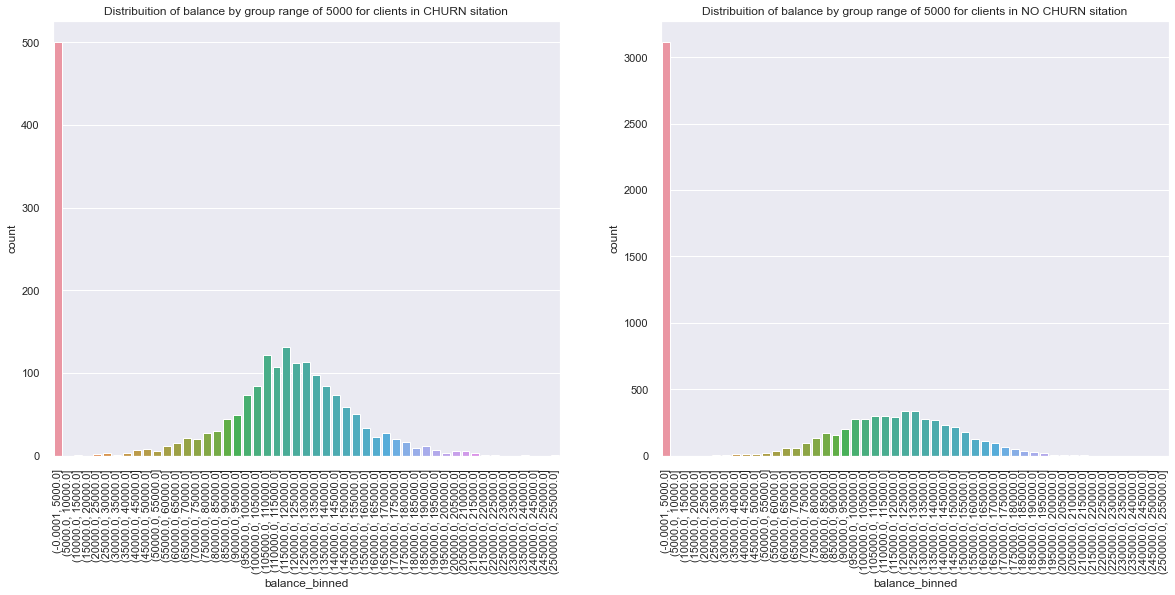

In [35]:
plt.figure(figsize=(20,8))

# Distribuition of balance by group range of 5.000 for clients in CHURN sitation

plt.subplot(1,2,1)

# settings
bins1 = list (np.arange(-1e-4, 255000, 5000))
aux_churn['balance_binned'] = pd.cut(aux_churn['balance'], bins=bins1)

# Plot 
sns.countplot(x=aux_churn['balance_binned'])
plt.xticks(rotation='90');
plt.title('Distribuition of balance by group range of 5000 for clients in CHURN sitation');


# Distribuition of balance by group range of 5000 for clients in NO CHURN sitation

plt.subplot(1,2,2)

# settings
bins1 = list (np.arange(-1e-4, 255000, 5000))
aux_nochurn['balance_binned'] = pd.cut(aux_nochurn['balance'], bins=bins1)

# Plot 
sns.countplot(x=aux_nochurn['balance_binned'])
plt.xticks(rotation='90');
plt.title('Distribuition of balance by group range of 5000 for clients in NO CHURN sitation');

<ipython-input-36-c95c6c5468bf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_bl['balance_binned'] = pd.cut(aux_bl['balance'], bins=bins)


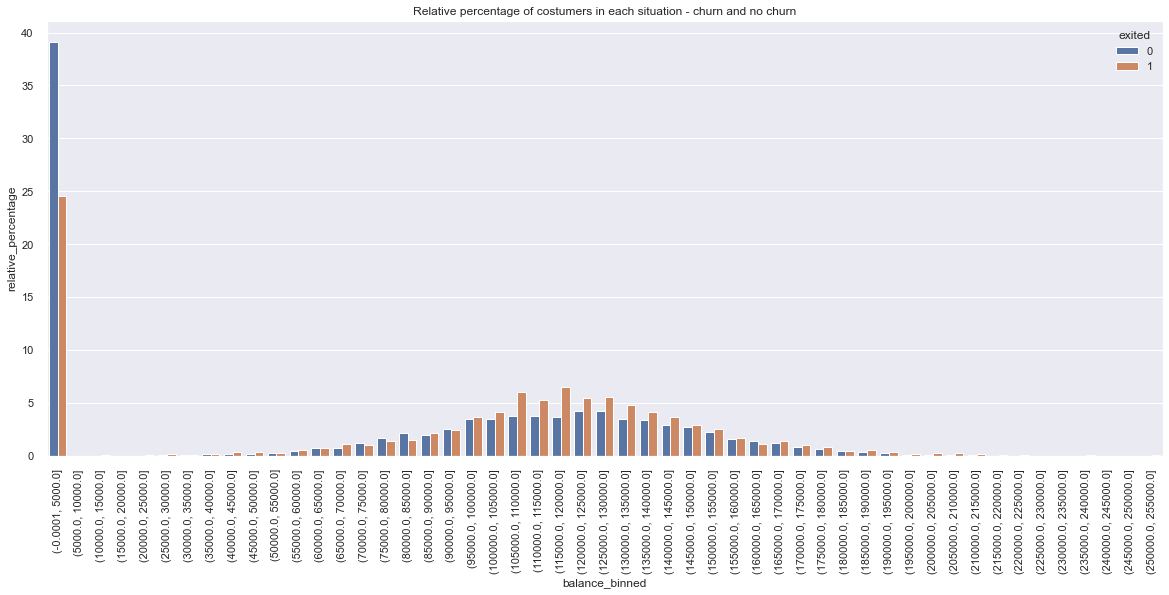

In [36]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_bl = df4[['balance', 'exited']]

# grouping the dataframe in bins of 5000 of salary
bins = list (np.arange(-1e-4, 255000, 5000))
aux_bl['balance_binned'] = pd.cut(aux_bl['balance'], bins=bins)
aux_bl_grouped = aux_bl[['balance_binned', 'exited', 'balance']].groupby(['balance_binned', 'exited']).count().reset_index()

# renaming columns
aux_bl_grouped.columns = ['balance_binned', 'exited', 'number_costumers']

# finding the total count for each situation - churn and no churn
bl_churn = aux_bl_grouped[aux_bl_grouped['exited'] == 1]['number_costumers'].sum()
bl_nochurn = aux_bl_grouped[aux_bl_grouped['exited'] == 0]['number_costumers'].sum()


# calculating relative percentage of costumers in each situation - churn and no churn
aux_bl_grouped['relative_percentage'] = aux_bl_grouped.apply(lambda x: ((x['number_costumers']/bl_churn)*100) if x['exited'] == 1 else ((x['number_costumers']/bl_nochurn)*100), axis=1)



# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='balance_binned', y='relative_percentage', hue='exited', data=aux_bl_grouped)
plt.xticks(rotation=90);
plt.title('Relative percentage of costumers in each situation - churn and no churn');

In [37]:
# % of ACTIVE costumers with a balance of zero

bl_zero_nochurn = (aux_nochurn[aux_nochurn['balance']==0].shape[0]/bl_nochurn)*100
bl_zero_nochurn

39.143538867261086

In [38]:
# % of CHURN costumers with a balance of zero

bl_zero_churn = (aux_churn[aux_churn['balance']==0].shape[0]/bl_churn)*100
bl_zero_churn

24.545900834560626

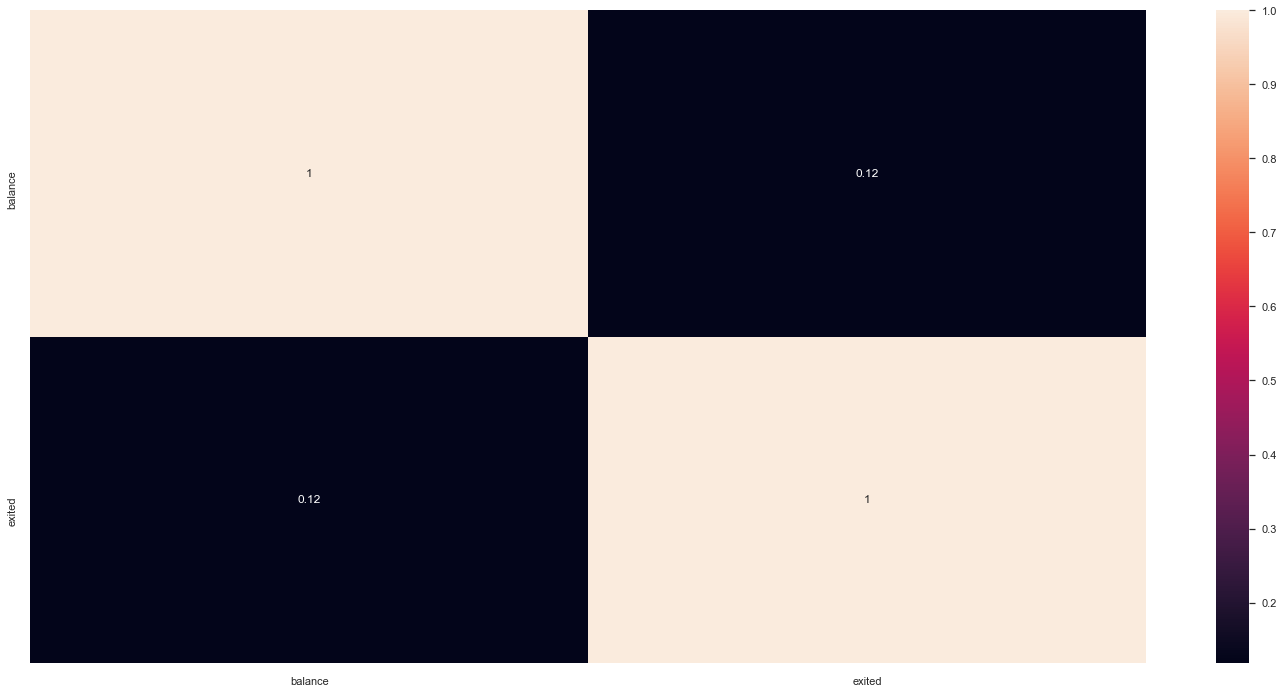

In [39]:
sns.heatmap(aux_bl.corr(method='pearson'), annot=True);

### H3. Newer costumers tend to have higher churn rates than the old ones.

**Response:** FALSE

High tenure -> CHURN

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


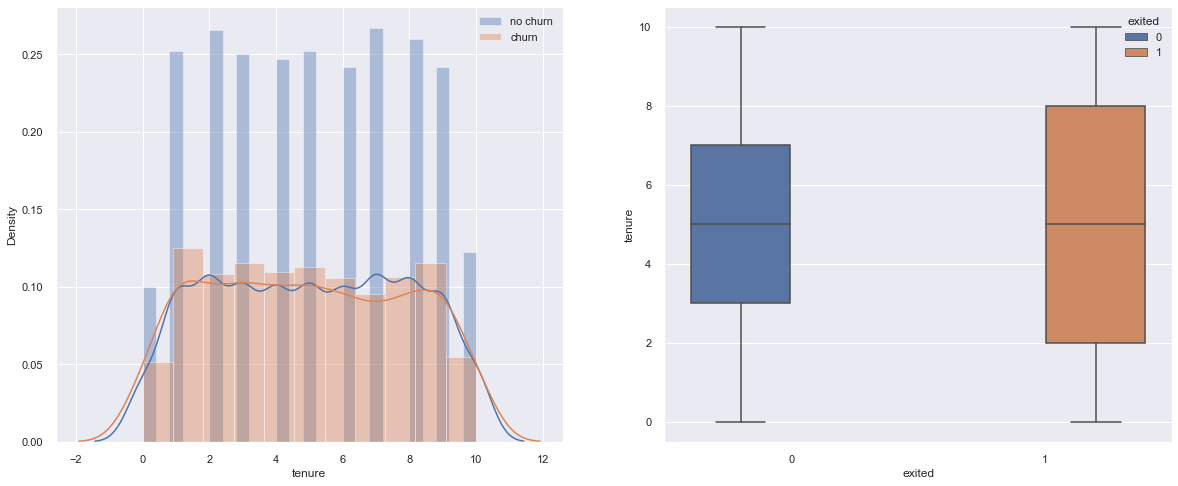

In [40]:
# Plot of tenure vs churn situation

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(aux_nochurn['tenure'], kde=True, label='no churn')
sns.distplot(aux_churn['tenure'], kde=True, label='churn')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot(x='exited', y='tenure', hue='exited', data=df4);

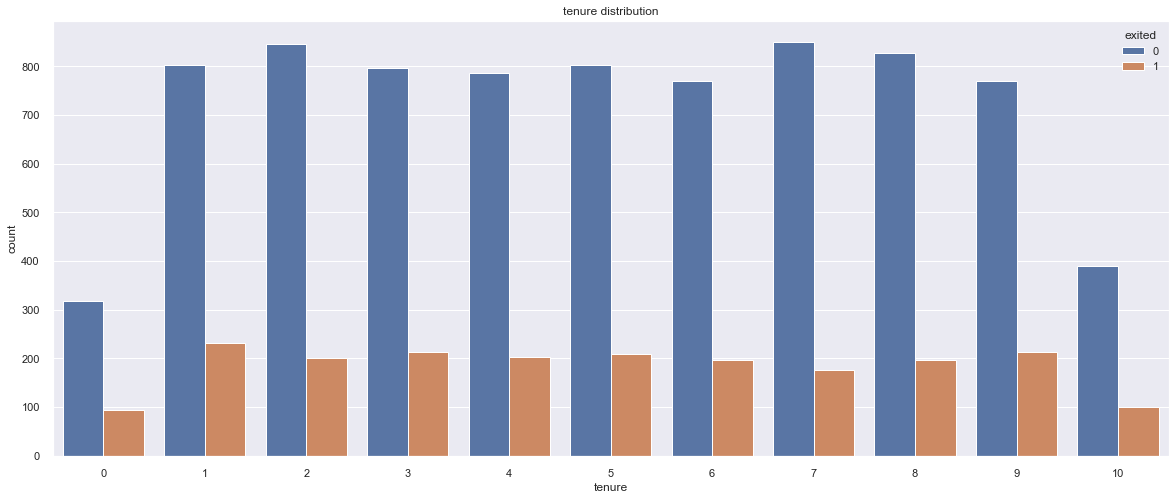

In [41]:
# Plot - tenure distribution

plt.figure(figsize=(20,8))

sns.countplot(x='tenure', hue='exited', data=df4).set_title('tenure distribution');


<ipython-input-42-ebf441ad377b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_ten['number_costumers'] = 'NaN'


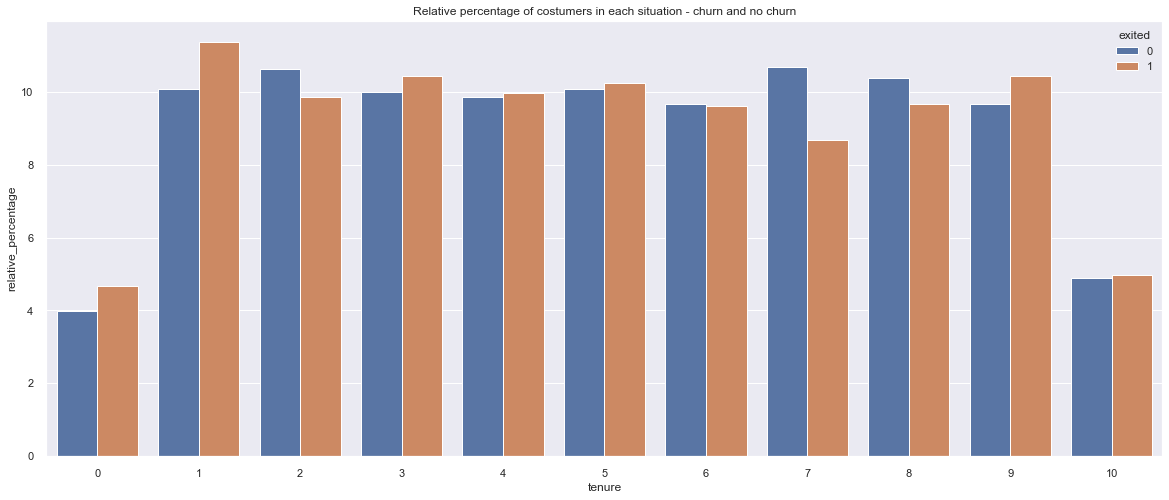

In [42]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_ten = df4[['tenure', 'exited']]

# create new columns
aux_ten['number_costumers'] = 'NaN'

aux_ten_grouped = aux_ten[['tenure', 'exited', 'number_costumers']].groupby(['tenure', 'exited']).count().reset_index()

# finding the total count for each situation - churn and no churn
aux_ten_churn = aux_ten_grouped[aux_ten_grouped['exited'] == 1]['number_costumers'].sum()
aux_ten_nochurn = aux_ten_grouped[aux_ten_grouped['exited'] == 0]['number_costumers'].sum()

# calculating relative percentage of costumers in each situation - churn and no churn
aux_ten_grouped['relative_percentage'] = aux_ten_grouped.apply(lambda x: ((x['number_costumers']/aux_ten_churn)*100) if x['exited']==1 else ((x['number_costumers']/aux_ten_nochurn)*100), axis=1)

# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='tenure', y='relative_percentage', hue='exited', data=aux_ten_grouped)
plt.title('Relative percentage of costumers in each situation - churn and no churn');

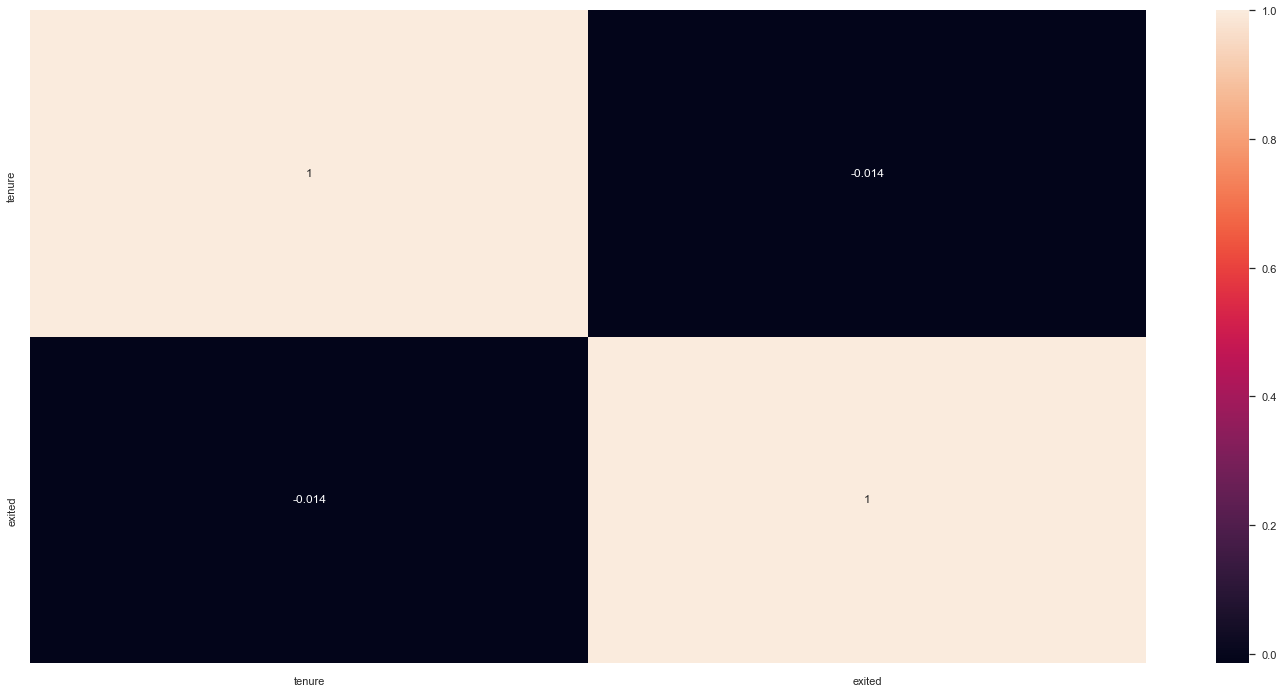

In [43]:
sns.heatmap(aux_ten.corr(method='pearson'), annot=True);

### H4. Young costumers have higher churn rate than the old ones.

**Response:** FALSE

High age -> CHURN

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


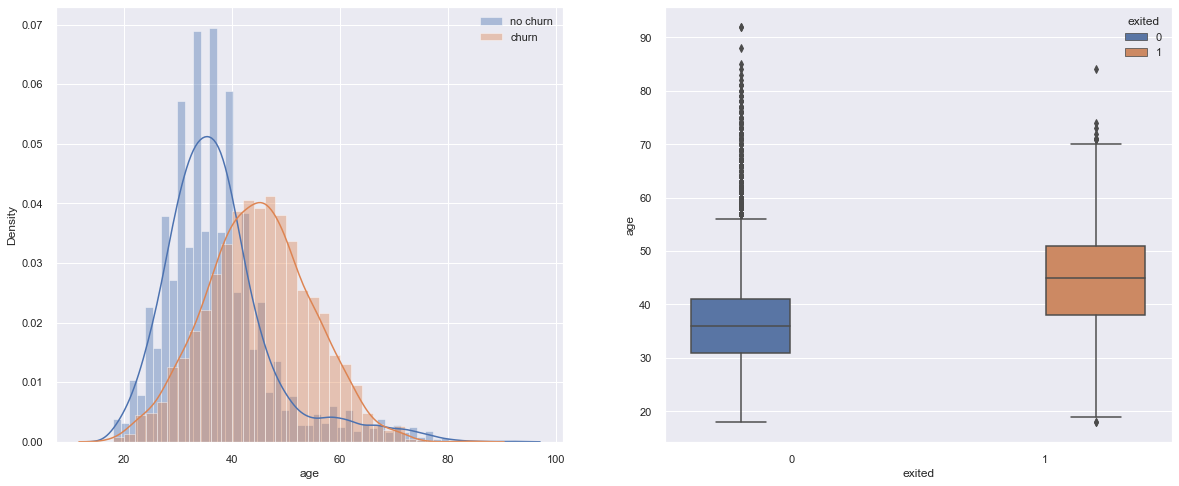

In [44]:
# Plot of age vs churn situation

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(aux_nochurn['age'], kde=True, label='no churn')
sns.distplot(aux_churn['age'], kde=True, label='churn')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot(x='exited', y='age', hue='exited', data=df4);

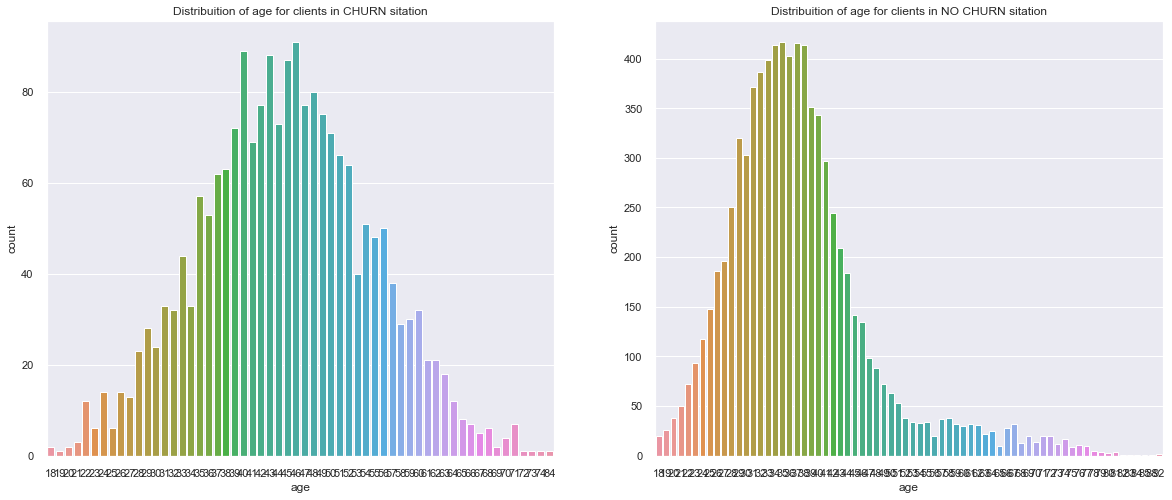

In [45]:
# Plot 
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.countplot(x=aux_churn['age'])
plt.title('Distribuition of age for clients in CHURN sitation');

plt.subplot(1,2,2)
sns.countplot(x=aux_nochurn['age'])
plt.title('Distribuition of age for clients in NO CHURN sitation');

<ipython-input-46-d360b8e1c037>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_age['number_costumers'] = 'NaN'


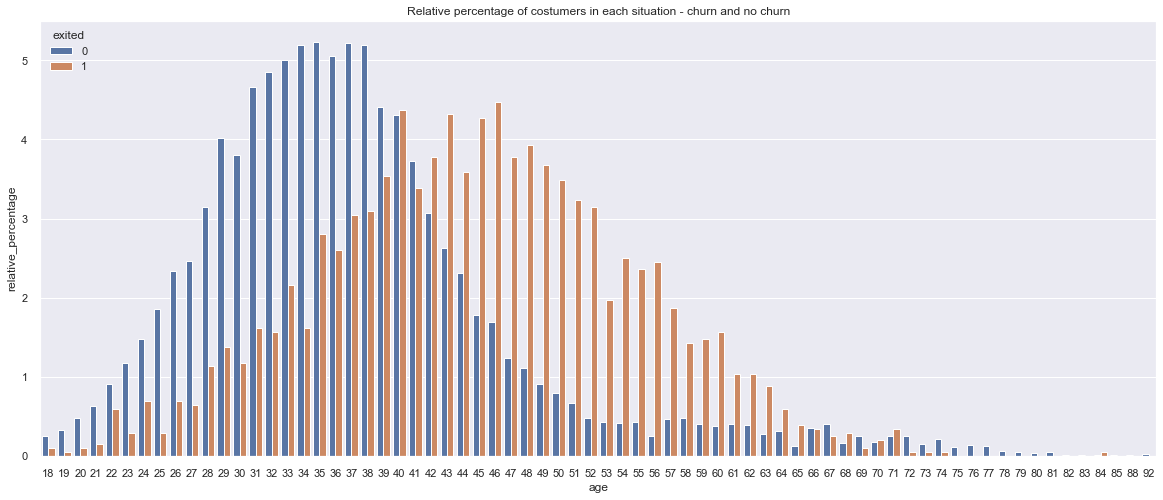

In [46]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_age = df4[['age', 'exited']]


# create new columns
aux_age['number_costumers'] = 'NaN'

aux_age_grouped = aux_age[['age', 'exited', 'number_costumers']].groupby(['age', 'exited']).count().reset_index()

# finding the total count for each situation - churn and no churn
aux_age_churn = aux_age_grouped[aux_age_grouped['exited'] == 1]['number_costumers'].sum()
aux_age_nochurn = aux_age_grouped[aux_age_grouped['exited'] == 0]['number_costumers'].sum()

# calculating relative percentage of costumers in each situation - churn and no churn
aux_age_grouped['relative_percentage'] = aux_age_grouped.apply(lambda x: ((x['number_costumers']/aux_age_churn)*100) if x['exited']==1 else ((x['number_costumers']/aux_age_nochurn)*100), axis=1)

# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='age', y='relative_percentage', hue='exited', data=aux_age_grouped)
plt.title('Relative percentage of costumers in each situation - churn and no churn');

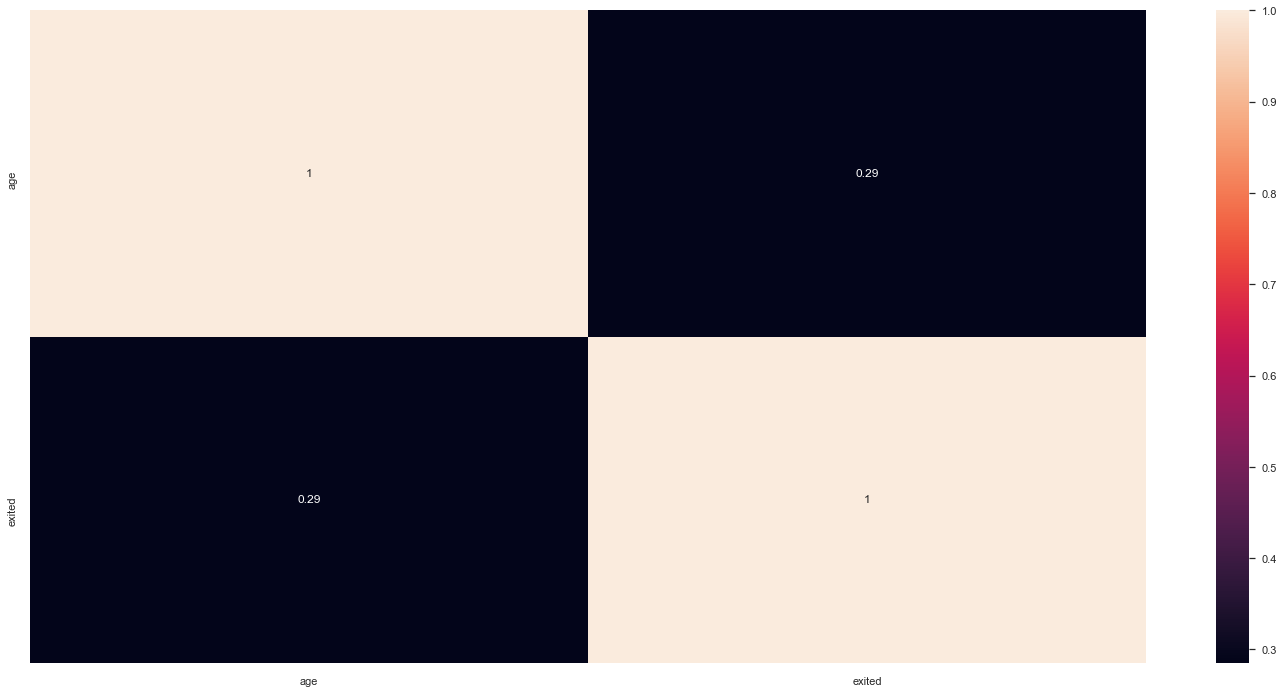

In [47]:
sns.heatmap(aux_age.corr(method='pearson'), annot=True);

### H5. Female costumers have higher churn rates than male costumers.

**Response:** TRUE

female -> CHURN

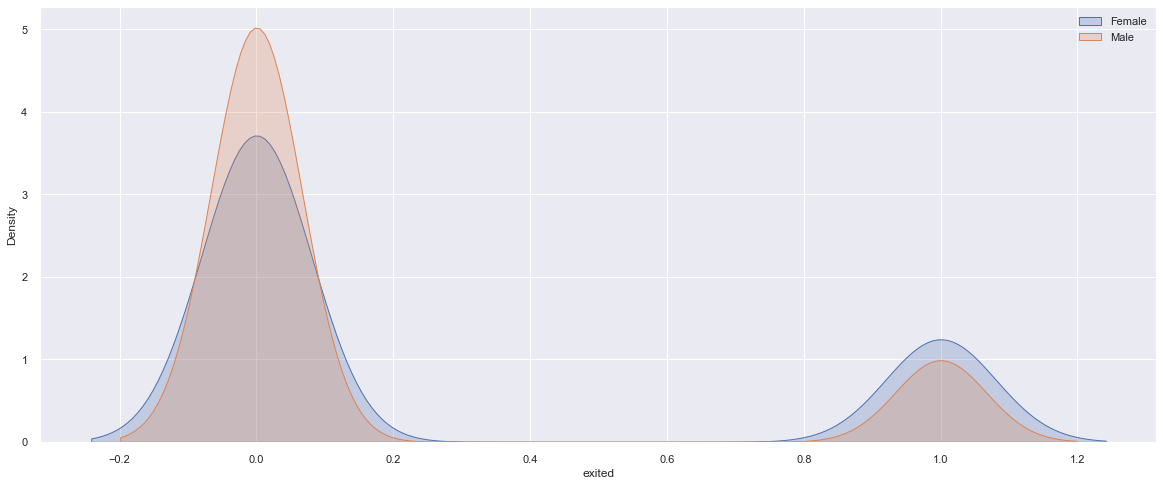

In [48]:
plt.figure(figsize=(20,8))
sns.kdeplot(df4[df4['gender'] == 'Female']['exited'], label='Female', shade=True)
sns.kdeplot(df4[df4['gender'] == 'Male']['exited'], label='Male', shade=True)
plt.legend();

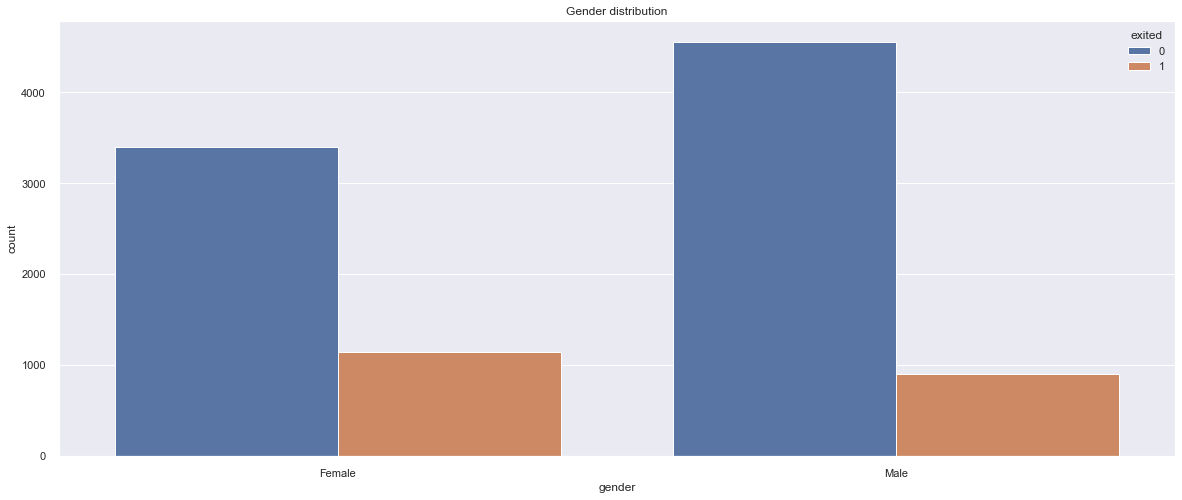

In [49]:
# Plot - Gender distribution 

plt.figure(figsize=(20,8))
sns.countplot(x='gender', hue='exited', data=df4).set_title('Gender distribution');


<ipython-input-50-56015cace9e0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_gender['number_costumers'] = 'NaN'


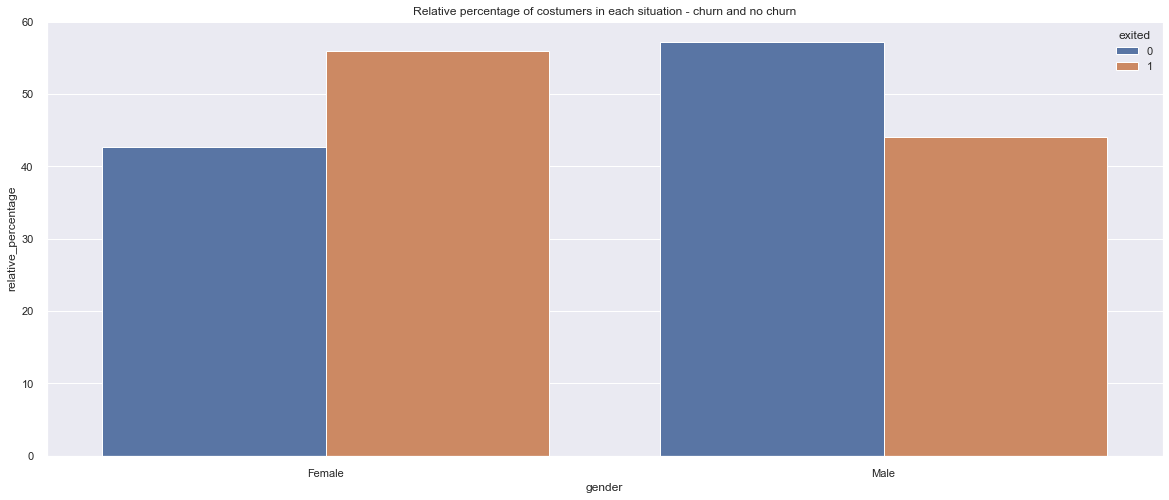

In [50]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_gender = df4[['gender', 'exited']]

# create new columns
aux_gender['number_costumers'] = 'NaN'

aux_gender_grouped = aux_gender[['gender', 'exited', 'number_costumers']].groupby(['gender', 'exited']).count().reset_index()

# finding the total count for each situation - churn and no churn
aux_gender_churn = aux_gender_grouped[aux_gender_grouped['exited'] == 1]['number_costumers'].sum()
aux_gender_nochurn = aux_gender_grouped[aux_gender_grouped['exited'] == 0]['number_costumers'].sum()

# calculating relative percentage of costumers in each situation - churn and no churn
aux_gender_grouped['relative_percentage'] = aux_gender_grouped.apply(lambda x: ((x['number_costumers']/aux_gender_churn)*100) if x['exited']==1 else ((x['number_costumers']/aux_gender_nochurn)*100), axis=1)

# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='gender', y='relative_percentage', hue='exited', data=aux_gender_grouped)
plt.title('Relative percentage of costumers in each situation - churn and no churn');

In [51]:
aux_gender_grouped

,gender,exited,number_costumers,relative_percentage
0,Female,0,3404,42.74771
1,Female,1,1139,55.91556
2,Male,0,4559,57.25229
3,Male,1,898,44.08444


### H6. Churn rate are higher in costumers from Spain than from France and Germany.

**Response:** TRUE

France -> CHURN

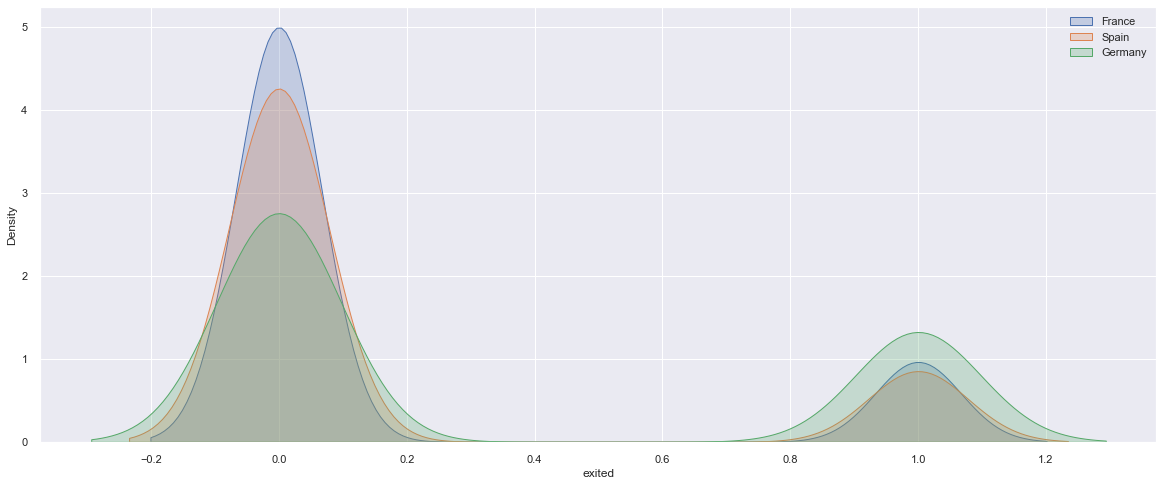

In [52]:
# Plot - Density Distribution between genders for CHURN situations

plt.figure(figsize=(20,8))
sns.kdeplot(df4[df4['geography'] == 'France']['exited'], label='France', shade=True)
sns.kdeplot(df4[df4['geography'] == 'Spain']['exited'], label='Spain', shade=True)
sns.kdeplot(df4[df4['geography'] == 'Germany']['exited'], label='Germany', shade=True)
plt.legend();

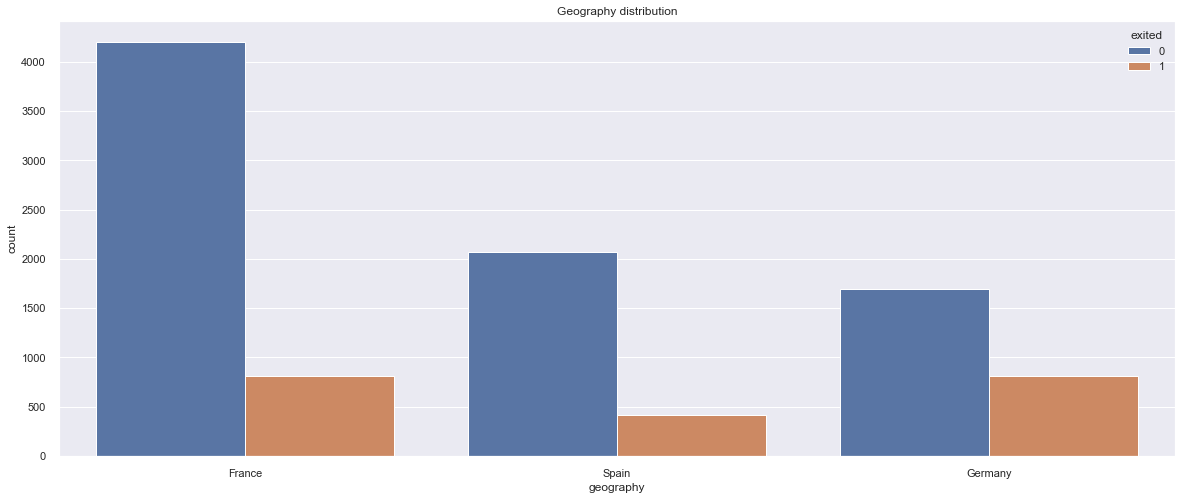

In [53]:
# Plot - Geography distribution 
plt.figure(figsize=(20,8))
sns.countplot(x='geography', hue='exited', data=df4).set_title('Geography distribution');

<ipython-input-54-143766d4c25e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_geo['number_costumers'] = 'NaN'


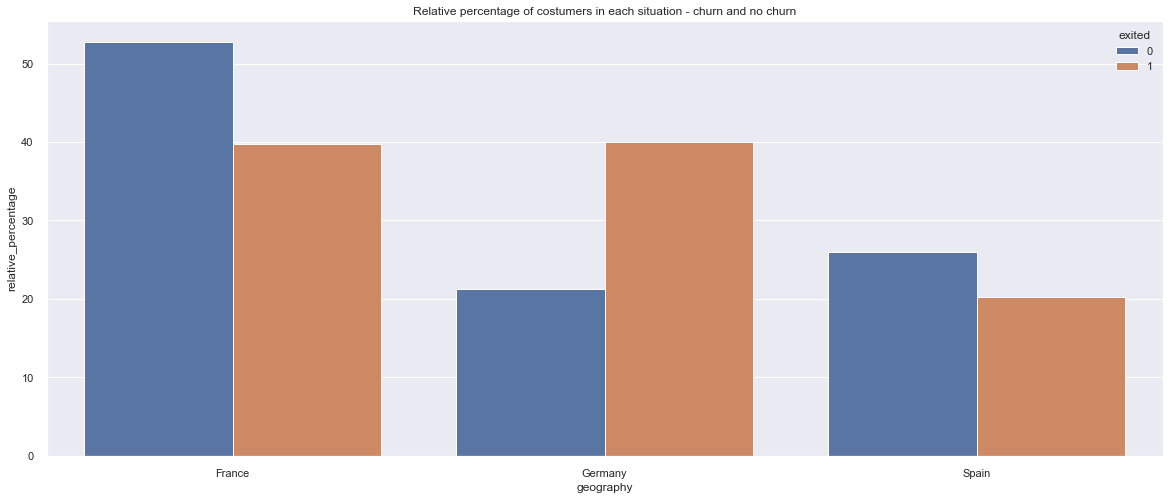

In [54]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_geo = df4[['geography', 'exited']]

# create new columns
aux_geo['number_costumers'] = 'NaN'

aux_geo_grouped = aux_geo[['geography', 'exited', 'number_costumers']].groupby(['geography', 'exited']).count().reset_index()

# finding the total count for each situation - churn and no churn
aux_geo_churn = aux_geo_grouped[aux_geo_grouped['exited'] == 1]['number_costumers'].sum()
aux_geo_nochurn = aux_geo_grouped[aux_geo_grouped['exited'] == 0]['number_costumers'].sum()

# calculating relative percentage of costumers in each situation - churn and no churn
aux_geo_grouped['relative_percentage'] = aux_geo_grouped.apply(lambda x: ((x['number_costumers']/aux_geo_churn)*100) if x['exited']==1 else ((x['number_costumers']/aux_geo_nochurn)*100), axis=1)

# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='geography', y='relative_percentage', hue='exited', data=aux_geo_grouped)
plt.title('Relative percentage of costumers in each situation - churn and no churn');

In [55]:
aux_geo_grouped

,geography,exited,number_costumers,relative_percentage
0,France,0,4204,52.79417
1,France,1,810,39.76436
2,Germany,0,1695,21.28595
3,Germany,1,814,39.96073
4,Spain,0,2064,25.91988
5,Spain,1,413,20.27491


### H7. Costumers with no credit card have higher churn rate than the ones that have.

**Response:** FALSE

Has credit card -> CHURN

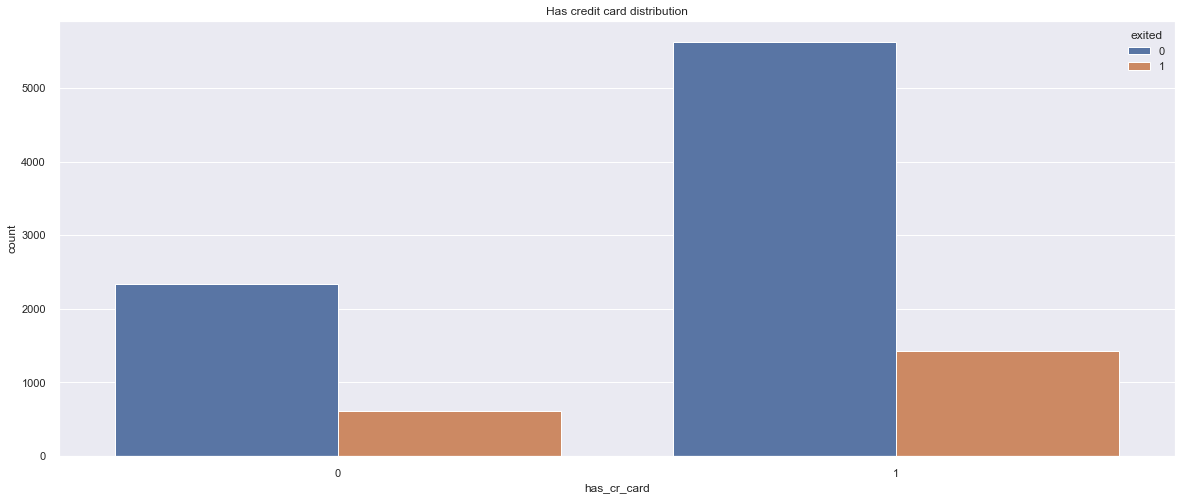

In [56]:
# Plot - has credit card distribution 

plt.figure(figsize=(20,8))
sns.countplot(x='has_cr_card', hue='exited', data=df4).set_title('Has credit card distribution');


<ipython-input-57-73e3daa60894>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_cred['number_costumers'] = 'NaN'


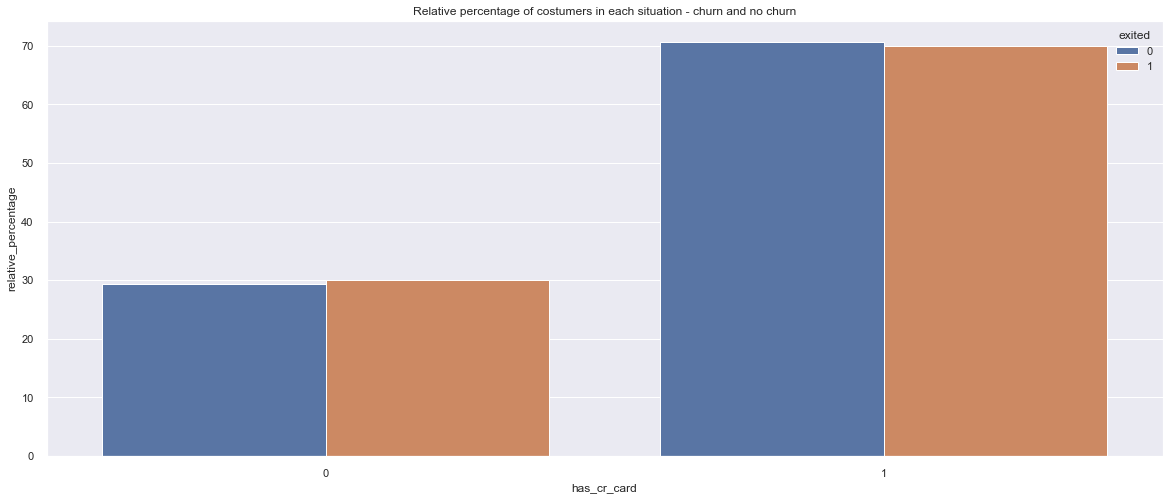

In [57]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_cred = df4[['has_cr_card', 'exited']]

# create new columns
aux_cred['number_costumers'] = 'NaN'

aux_cred_grouped = aux_cred[['has_cr_card', 'exited', 'number_costumers']].groupby(['has_cr_card', 'exited']).count().reset_index()

# finding the total count for each situation - churn and no churn
aux_cred_churn = aux_cred_grouped[aux_cred_grouped['exited'] == 1]['number_costumers'].sum()
aux_cred_nochurn = aux_cred_grouped[aux_cred_grouped['exited'] == 0]['number_costumers'].sum()

# calculating relative percentage of costumers in each situation - churn and no churn
aux_cred_grouped['relative_percentage'] = aux_cred_grouped.apply(lambda x: ((x['number_costumers']/aux_cred_churn)*100) if x['exited']==1 else ((x['number_costumers']/aux_cred_nochurn)*100), axis=1)

# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='has_cr_card', y='relative_percentage', hue='exited', data=aux_cred_grouped)
plt.title('Relative percentage of costumers in each situation - churn and no churn');

In [58]:
aux_cred_grouped

,has_cr_card,exited,number_costumers,relative_percentage
0,0,0,2332,29.28545
1,0,1,613,30.09327
2,1,0,5631,70.71455
3,1,1,1424,69.90673


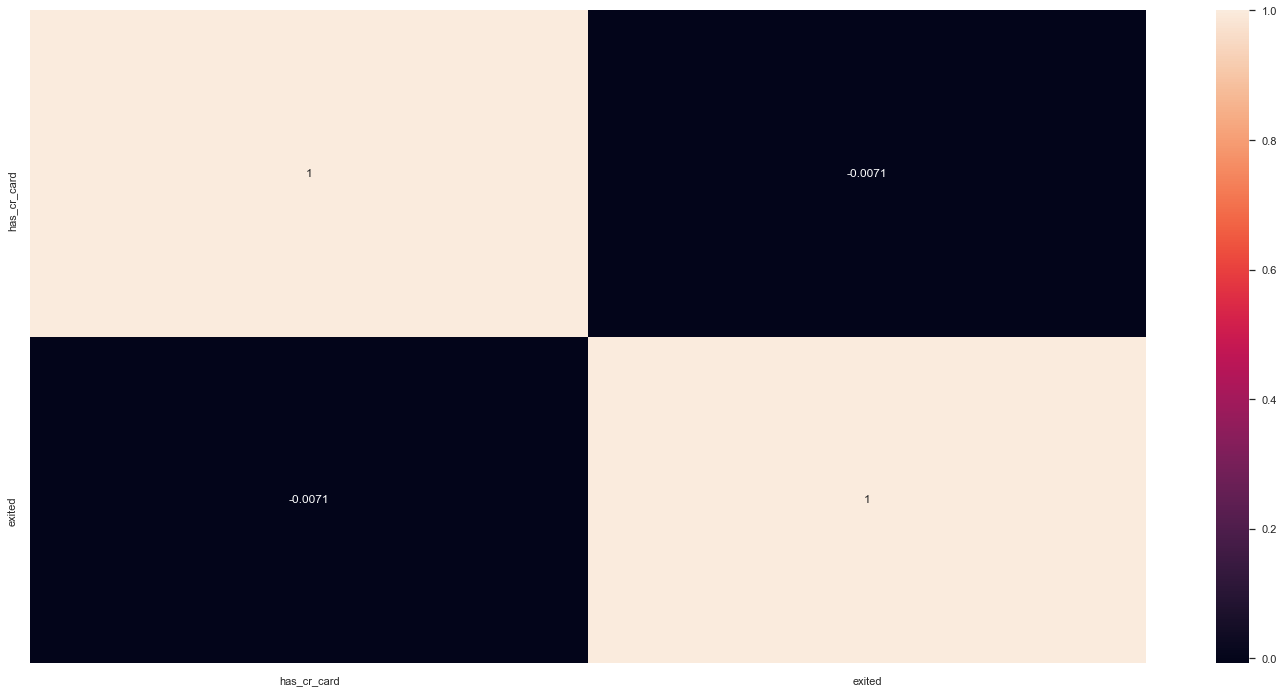

In [59]:
sns.heatmap(aux_cred.corr(method='pearson'), annot=True);

### H8. Costumers that use one product from the bank have higher churn rate.

**Response:** TRUE

One product -> CHURN

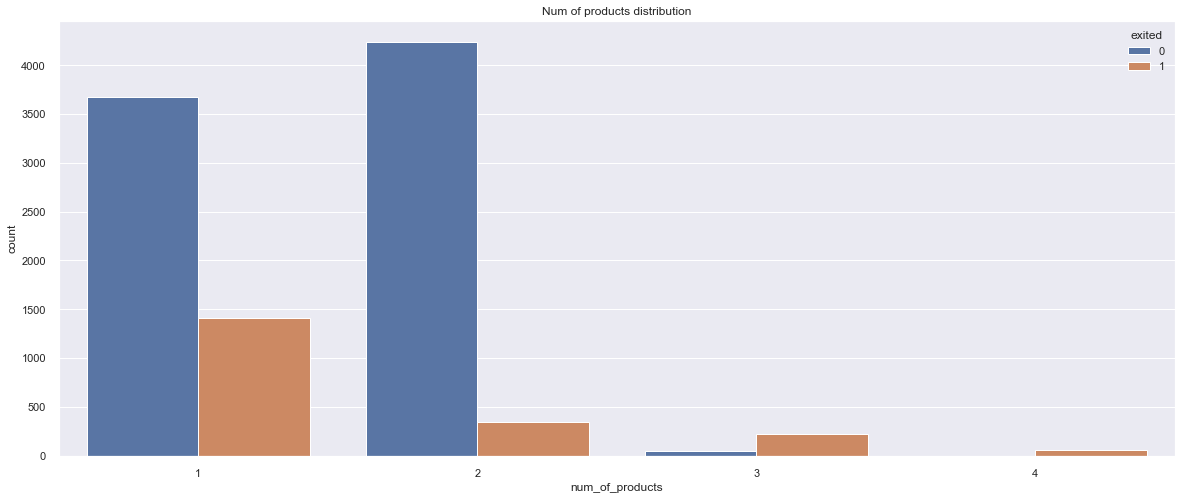

In [60]:
# Plot - num of products card distribution 

plt.figure(figsize=(20,8))
sns.countplot(x='num_of_products', hue='exited', data=df4).set_title('Num of products distribution');


<ipython-input-61-a961d85277f0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_nprod['number_costumers'] = 'NaN'


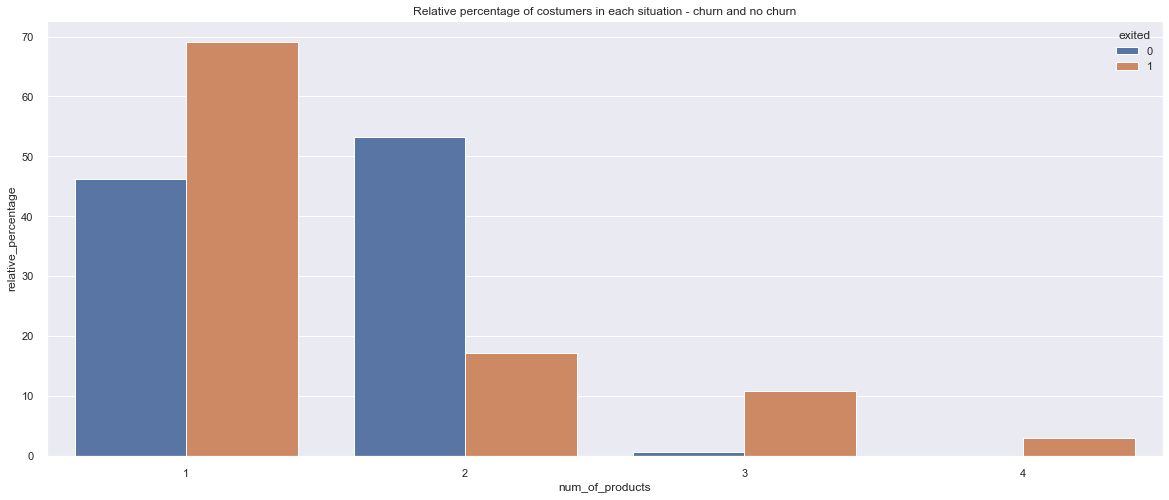

In [61]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_nprod = df4[['num_of_products', 'exited']]

# create new columns
aux_nprod['number_costumers'] = 'NaN'

aux_nprod_grouped = aux_nprod[['num_of_products', 'exited', 'number_costumers']].groupby(['num_of_products', 'exited']).count().reset_index()

# finding the total count for each situation - churn and no churn
aux_nprod_churn = aux_nprod_grouped[aux_nprod_grouped['exited'] == 1]['number_costumers'].sum()
aux_nprod_nochurn = aux_nprod_grouped[aux_nprod_grouped['exited'] == 0]['number_costumers'].sum()

# calculating relative percentage of costumers in each situation - churn and no churn
aux_nprod_grouped['relative_percentage'] = aux_nprod_grouped.apply(lambda x: ((x['number_costumers']/aux_nprod_churn)*100) if x['exited']==1 else ((x['number_costumers']/aux_nprod_nochurn)*100), axis=1)

# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='num_of_products', y='relative_percentage', hue='exited', data=aux_nprod_grouped)
plt.title('Relative percentage of costumers in each situation - churn and no churn');

In [62]:
aux_nprod_grouped

,num_of_products,exited,number_costumers,relative_percentage
0,1,0,3675,46.15095
1,1,1,1409,69.17035
2,2,0,4242,53.27138
3,2,1,348,17.08395
4,3,0,46,0.57767
5,3,1,220,10.80020
6,4,1,60,2.94551


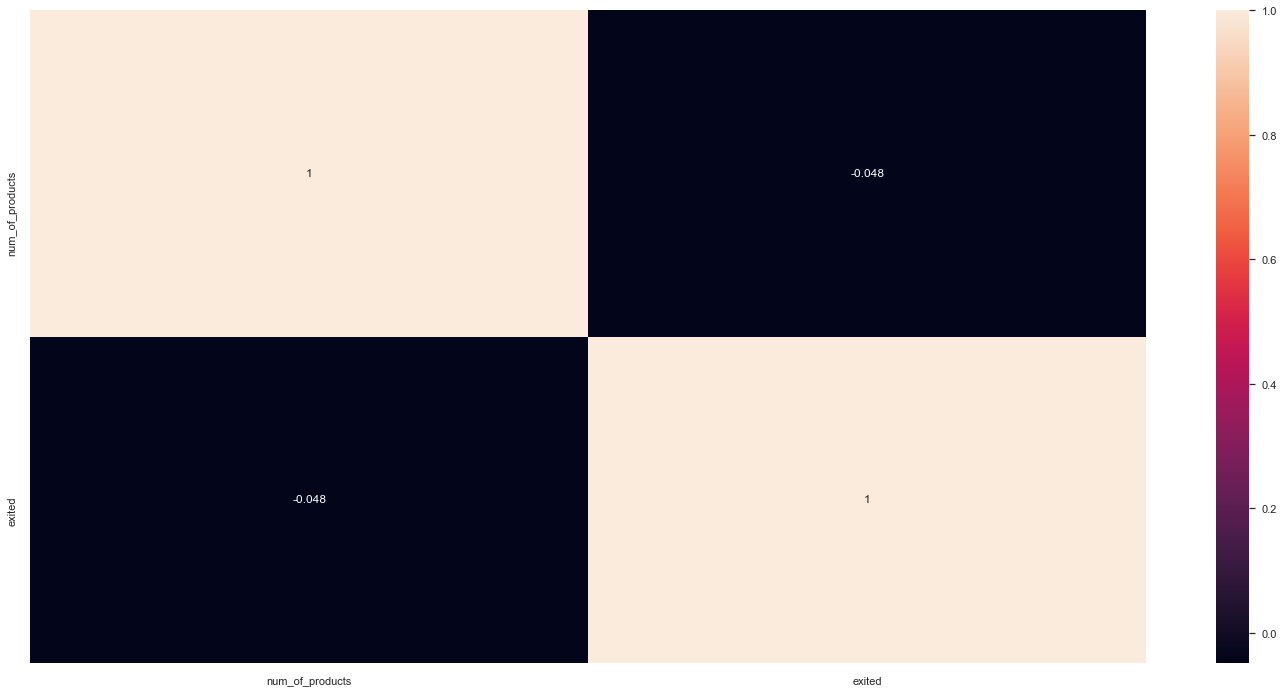

In [63]:
sns.heatmap(aux_nprod.corr(method='pearson'), annot=True);

### H9. Costumers with low credit score have higher churn rate than the ones with high score.

**Response:** TRUE

low credit score -> CHURN

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


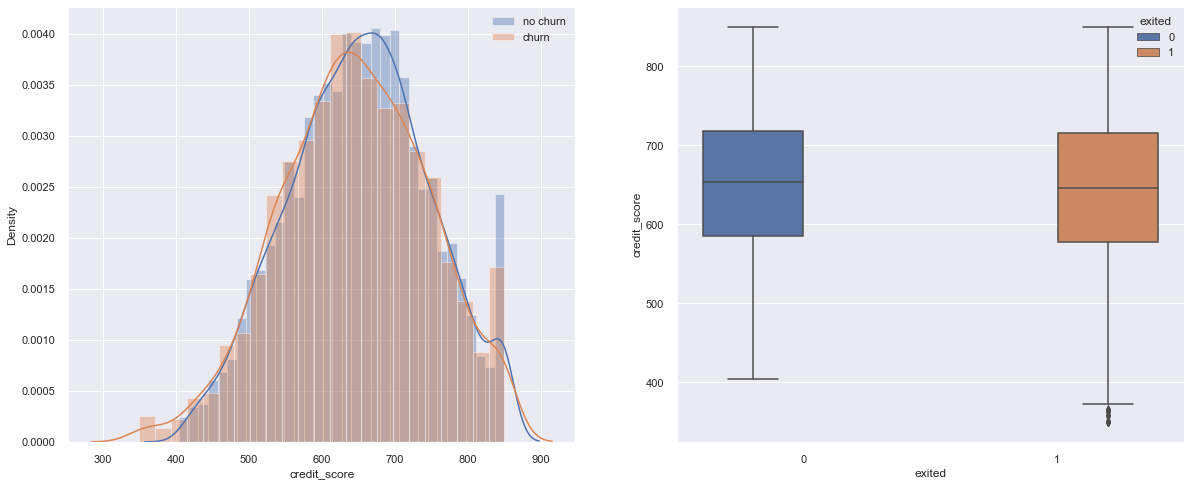

In [64]:
# Plot of credit score vs churn situation

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(aux_nochurn['credit_score'], kde=True, label='no churn')
sns.distplot(aux_churn['credit_score'], kde=True, label='churn')
plt.legend();

plt.subplot(1,2,2)
sns.boxplot(x='exited', y='credit_score', hue='exited', data=df4);

In [65]:
df4['credit_score'].describe()

count   10000.00000
mean      650.52880
std        96.65330
min       350.00000
25%       584.00000
50%       652.00000
75%       718.00000
max       850.00000
Name: credit_score, dtype: float64

<ipython-input-66-f63faa4a501a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_churn['credit_score_binned'] = pd.cut(aux_churn['credit_score'], bins=bins2)
<ipython-input-66-f63faa4a501a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_nochurn['credit_score_binned'] = pd.cut(aux_nochurn['credit_score'], bins=bins2)


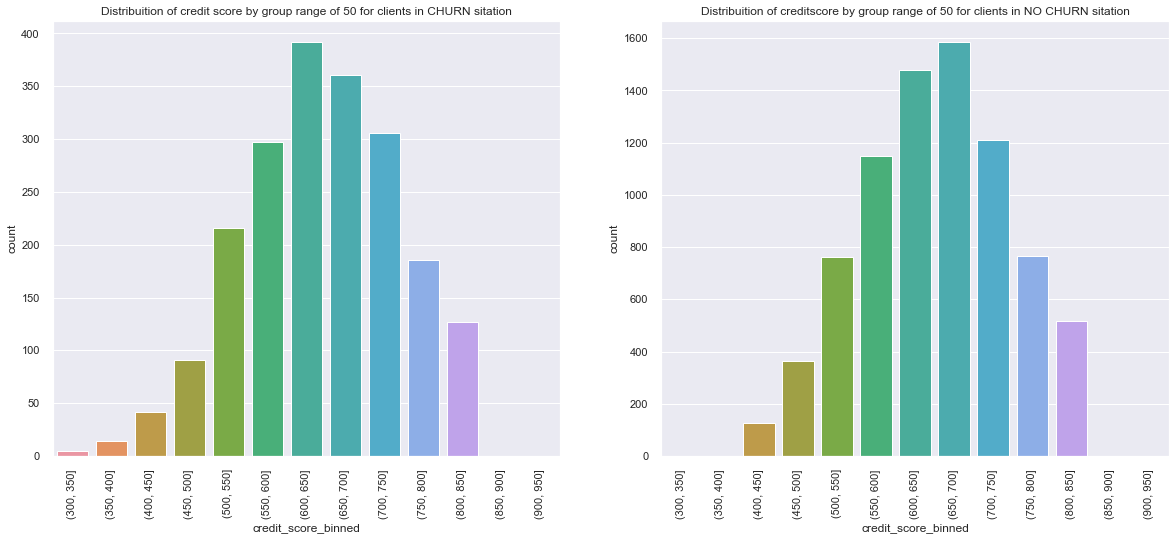

In [66]:
plt.figure(figsize=(20,8))

# Distribuition of credit score by group range of 50 for clients in CHURN sitation

plt.subplot(1,2,1)

# settings
bins2 = list (np.arange(300, 1000, 50))
aux_churn['credit_score_binned'] = pd.cut(aux_churn['credit_score'], bins=bins2)

# Plot 
sns.countplot(x=aux_churn['credit_score_binned'])
plt.xticks(rotation='90');
plt.title('Distribuition of credit score by group range of 50 for clients in CHURN sitation');


# Distribuition of balance by group range of 5000 for clients in NO CHURN sitation

plt.subplot(1,2,2)

# settings
bins2 = list (np.arange(300, 1000, 50))
aux_nochurn['credit_score_binned'] = pd.cut(aux_nochurn['credit_score'], bins=bins2)

# Plot 
sns.countplot(x=aux_nochurn['credit_score_binned'])
plt.xticks(rotation='90');
plt.title('Distribuition of creditscore by group range of 50 for clients in NO CHURN sitation');

<ipython-input-67-d6bad1a26032>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_cs['credit_score_binned'] = pd.cut(aux_cs['credit_score'], bins=bins3)


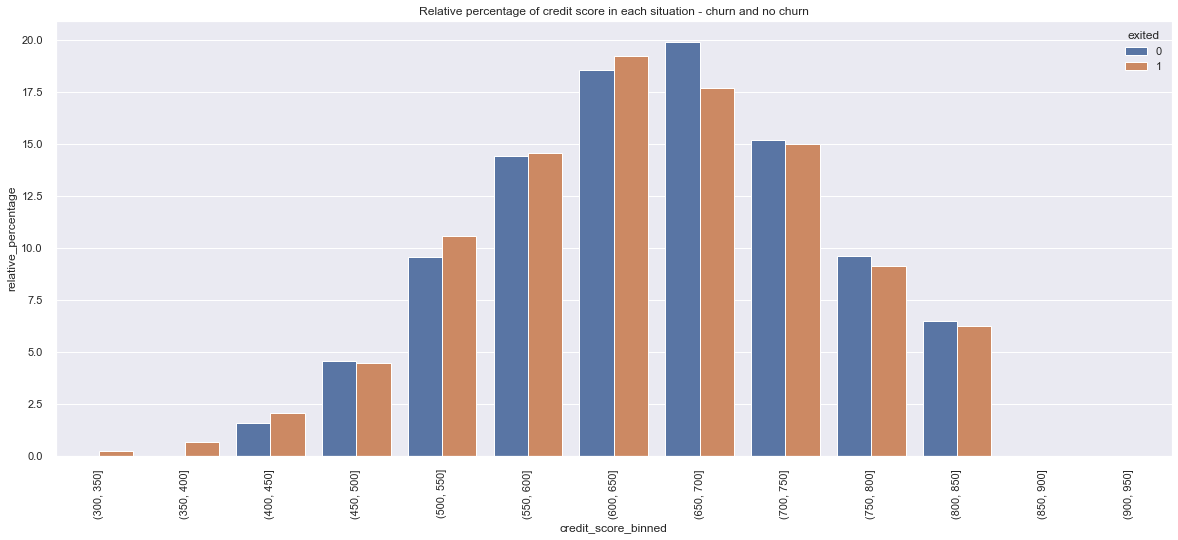

In [67]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_cs = df4[['credit_score', 'exited']]

# grouping the dataframe in bins of 50 of credit score
bins3 = list (np.arange(300, 1000, 50))
aux_cs['credit_score_binned'] = pd.cut(aux_cs['credit_score'], bins=bins3)
aux_cs_grouped = aux_cs[['credit_score_binned', 'exited', 'credit_score']].groupby(['credit_score_binned', 'exited']).count().reset_index()

# renaming columns
aux_cs_grouped.columns = ['credit_score_binned', 'exited', 'number_costumers']

# finding the total count for each situation - churn and no churn
cs_churn = aux_cs_grouped[aux_cs_grouped['exited'] == 1]['number_costumers'].sum()
cs_nochurn = aux_cs_grouped[aux_cs_grouped['exited'] == 0]['number_costumers'].sum()


# calculating relative percentage of costumers in each situation - churn and no churn
aux_cs_grouped['relative_percentage'] = aux_cs_grouped.apply(lambda x: ((x['number_costumers']/cs_churn)*100) if x['exited'] == 1 else ((x['number_costumers']/cs_nochurn)*100), axis=1)

# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='credit_score_binned', y='relative_percentage', hue='exited', data=aux_cs_grouped)
plt.xticks(rotation=90);
plt.title('Relative percentage of credit score in each situation - churn and no churn');

In [68]:
aux_cs_grouped

,credit_score_binned,exited,number_costumers,relative_percentage
0,"(300, 350]",0,0,0.00000
1,"(300, 350]",1,5,0.24546
2,"(350, 400]",0,0,0.00000
3,"(350, 400]",1,14,0.68729
4,"(400, 450]",0,128,1.60743
5,"(400, 450]",1,42,2.06186
6,"(450, 500]",0,363,4.55858
7,"(450, 500]",1,91,4.46735
8,"(500, 550]",0,762,9.56926
9,"(500, 550]",1,216,10.60383


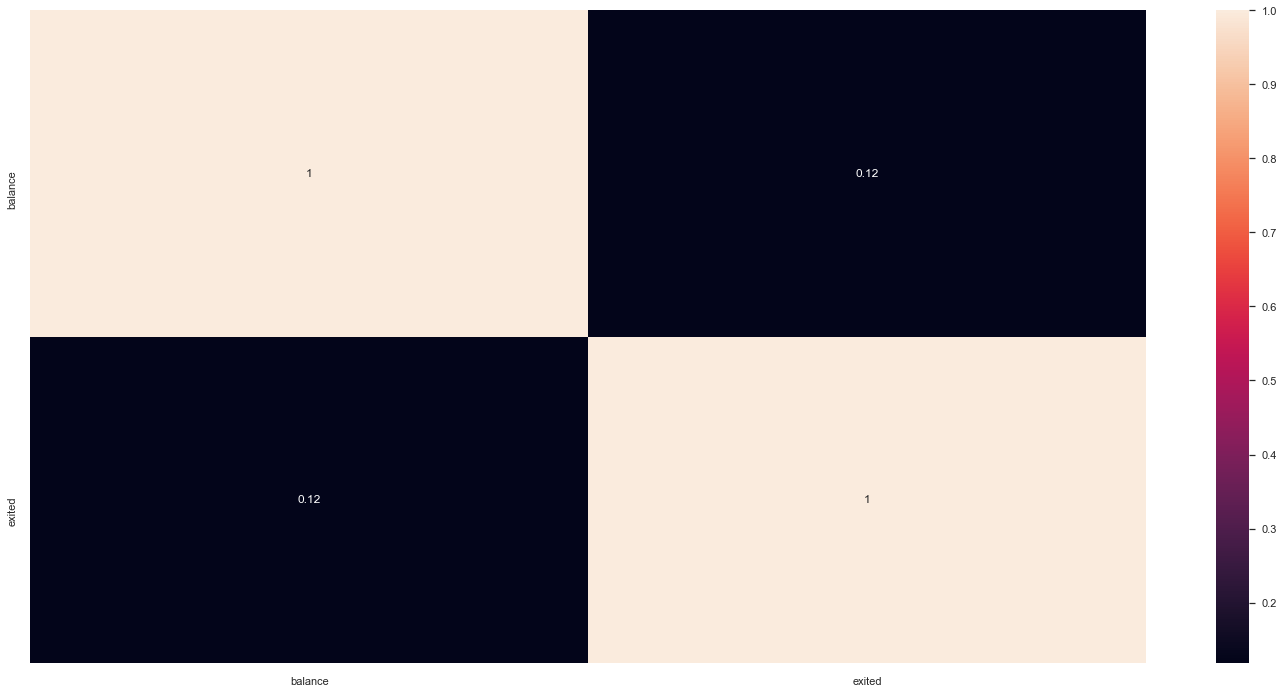

In [69]:
sns.heatmap(aux_bl.corr(method='pearson'), annot=True);

### H10. Costumers that are not active members have higher churn rate.

**Response:** TRUE

is not active member -> CHURN

In [70]:
aux_churn['is_active_member'].value_counts()

0    1302
1     735
Name: is_active_member, dtype: int64

In [71]:
aux_nochurn['is_active_member'].value_counts()

1    4416
0    3547
Name: is_active_member, dtype: int64

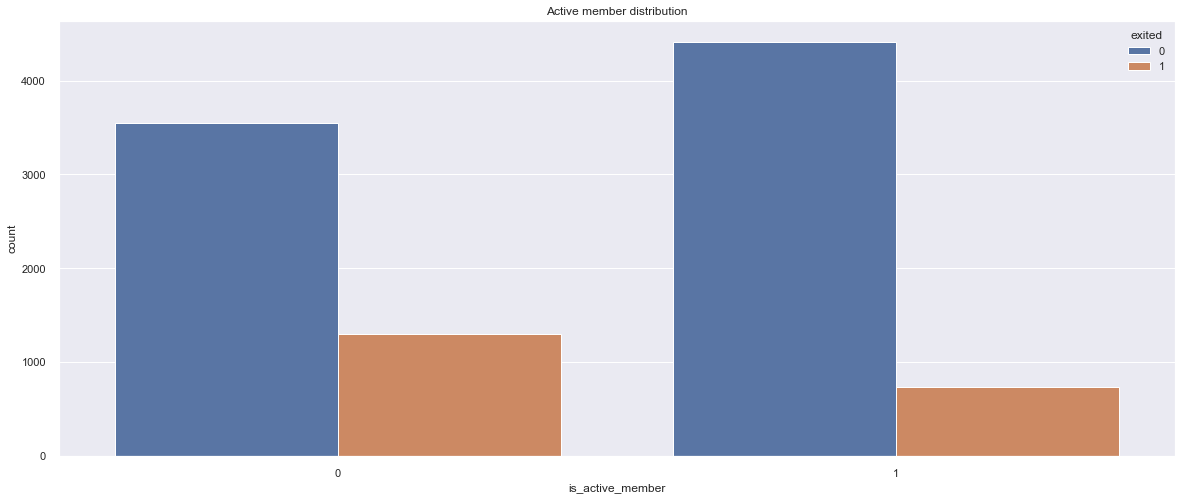

In [72]:
# Plot - Active member distribution 

plt.figure(figsize=(20,8))
sns.countplot(x='is_active_member', hue='exited', data=df4).set_title('Active member distribution');

<ipython-input-73-63d0f783c66c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_am['number_costumers'] = 'NaN'


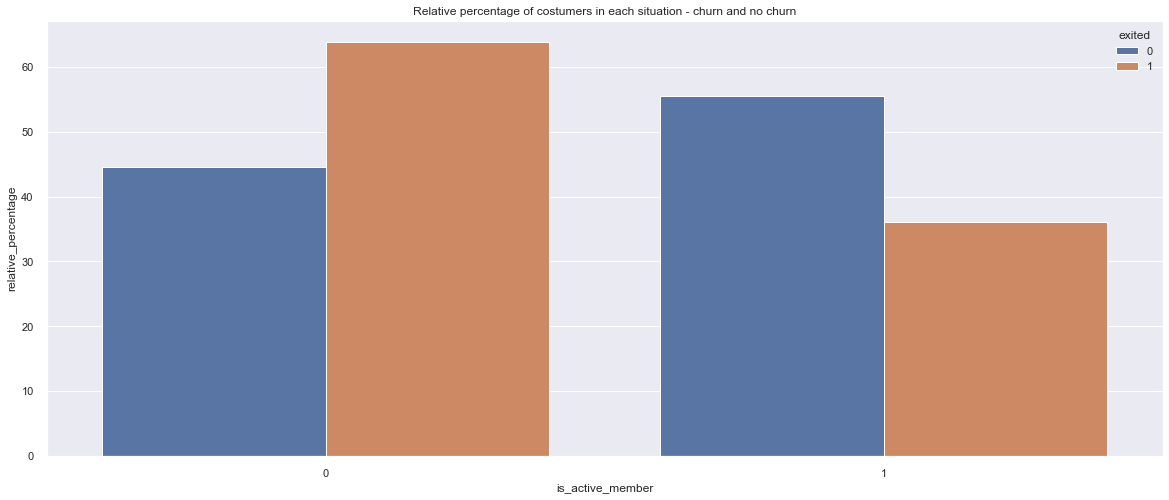

In [73]:
# Relative percentage of costumers in each situation - churn and no churn

# filtering dataframe

aux_am = df4[['is_active_member', 'exited']]

# create new columns
aux_am['number_costumers'] = 'NaN'

aux_am_grouped = aux_am[['is_active_member', 'exited', 'number_costumers']].groupby(['is_active_member', 'exited']).count().reset_index()

# finding the total count for each situation - churn and no churn
aux_am_churn = aux_am_grouped[aux_am_grouped['exited'] == 1]['number_costumers'].sum()
aux_am_nochurn = aux_am_grouped[aux_am_grouped['exited'] == 0]['number_costumers'].sum()

# calculating relative percentage of costumers in each situation - churn and no churn
aux_am_grouped['relative_percentage'] = aux_am_grouped.apply(lambda x: ((x['number_costumers']/aux_am_churn)*100) if x['exited']==1 else ((x['number_costumers']/aux_am_nochurn)*100), axis=1)

# Plot
plt.figure(figsize=(20,8))
sns.barplot(x='is_active_member', y='relative_percentage', hue='exited', data=aux_am_grouped)
plt.title('Relative percentage of costumers in each situation - churn and no churn');

In [74]:
aux_am_grouped

,is_active_member,exited,number_costumers,relative_percentage
0,0,0,3547,44.54351
1,0,1,1302,63.91753
2,1,0,4416,55.45649
3,1,1,735,36.08247


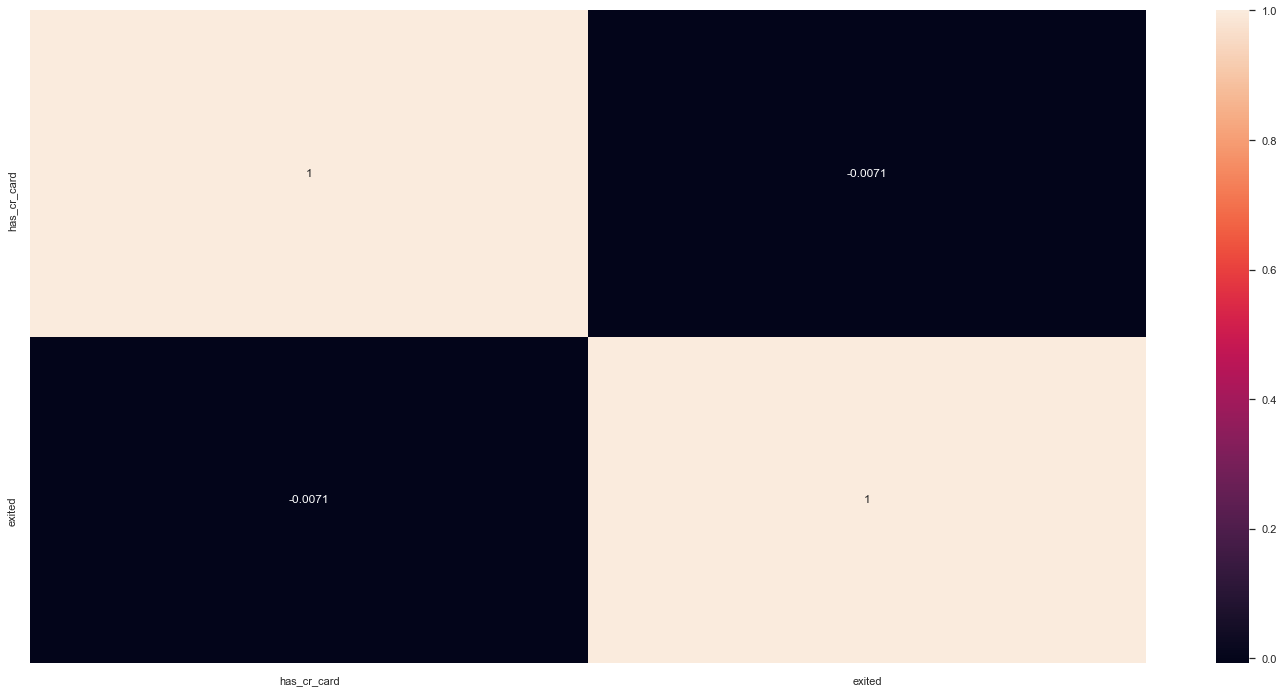

In [75]:
sns.heatmap(aux_cred.corr(method='pearson'), annot=True);

## 4.4 Análise Multivariada

### 4.4.1 Numerical Attributes

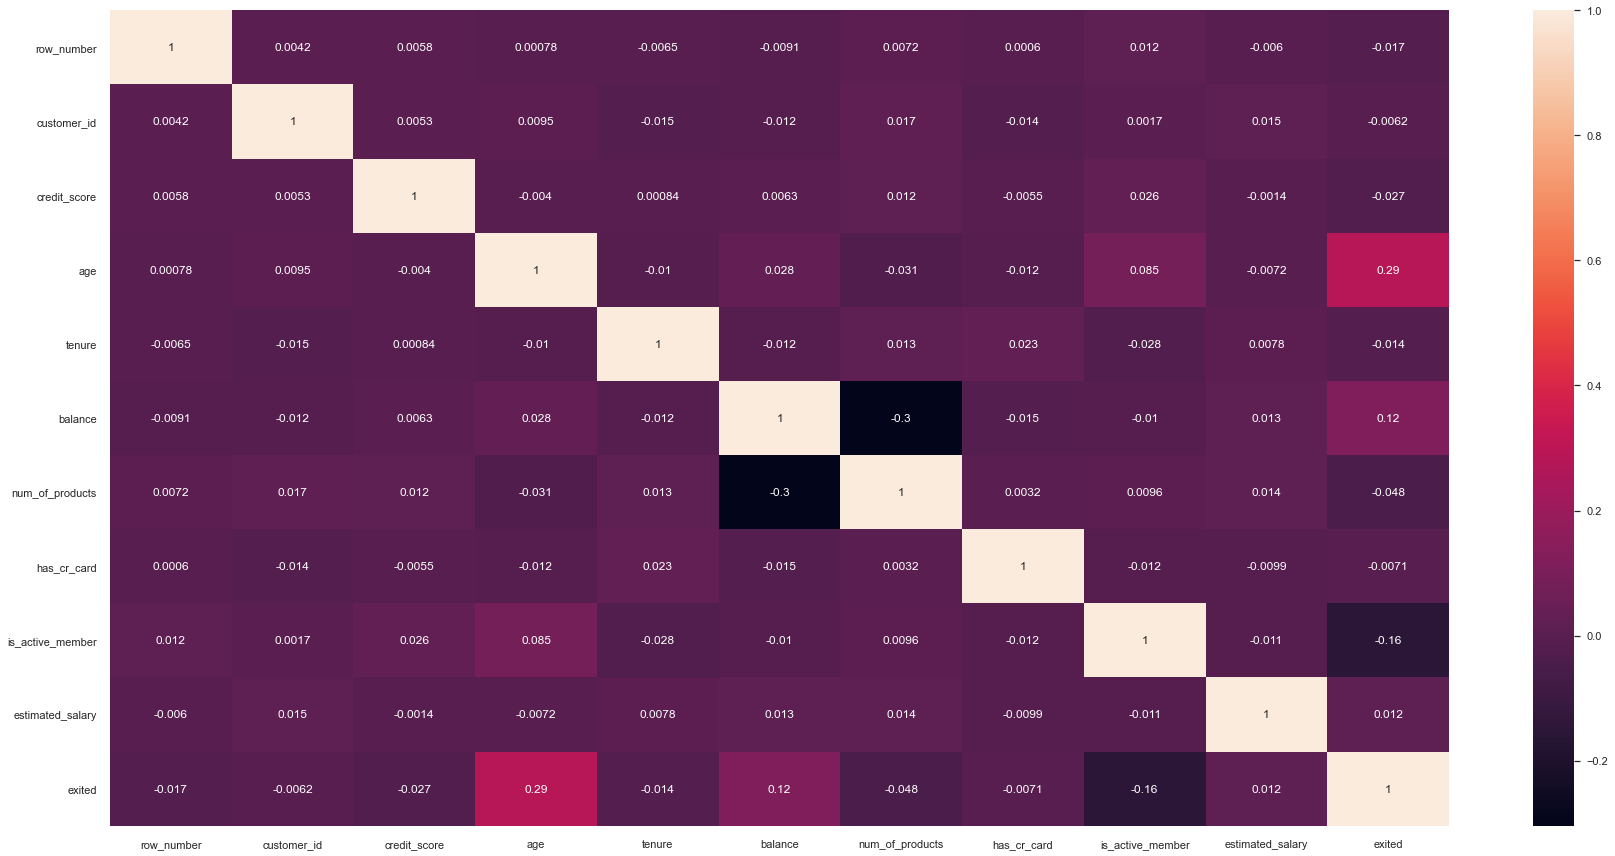

In [76]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(30, 15))
sns.heatmap(correlation, annot=True);

### 4.4.2 Multivariate Attributes

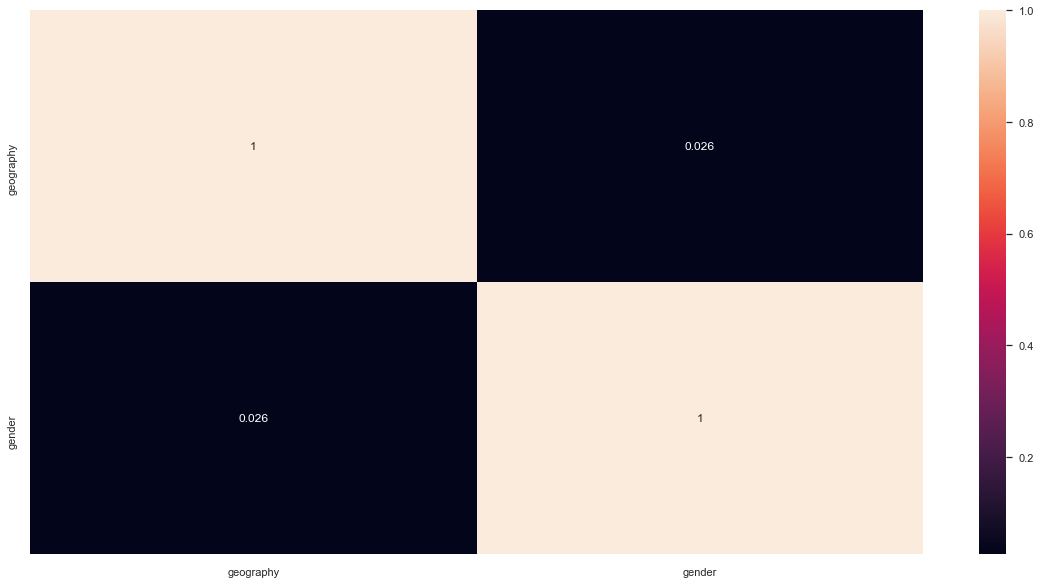

In [77]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = cramer_v(a['geography'], a['geography'])
a2 = cramer_v(a['geography'], a['gender'])

a3 = cramer_v(a['gender'], a['geography'])
a4 = cramer_v(a['gender'], a['gender'])


# Final dataset
d = pd.DataFrame({'geography': [a1,a2], 
             'gender': [a3,a4]})

d = d.set_index(d.columns)

plt.figure(figsize=(20, 10))
sns.heatmap(d, annot=True);

### SUMMARY


In [78]:
 # display columns complete description
pd.set_option('display.max_colwidth',None,'display.colheader_justify','left')



summary_eda = pd.DataFrame({'Hypothesis':['Costumers with lower salary tend have high churn rate than costumers with higher salaries.',
                                          'Costumers with low balance tend have high churn rate than costumers with high balance.',
                                          'Newer costumers tend to have higher churn rates than the old ones.',
                                          'Young costumers have higher churn rate than the old ones.',
                                          'Female costumers have higher churn rates than male costumers.',
                                          'Churn rate are higher in costumers from France than from Spain and Germany.',
                                          'Costumers with no credit card have higher churn rate than the ones that have.',
                                          'Costumers that use one product from the bank have higher churn rate.',
                                          'Costumers with low credit score have higher churn rate than the ones with high score.',
                                          'Costumers that are not active members have higher churn rate.'
                                         ],
                            'True / False':['False', 'False', 'False', 'False', 'True', 'False', 'True', 'True', 'True', 'True'],
                            'Relevance':['Low', 'High', 'Low', 'High', 'Low', 'Medium', 'Low', 'High', 'Medium', 'Medium']},
                            index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

summary_eda.style.set_properties(**{'text-align': 'left'}).set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])
summary_eda

,Hypothesis,True / False,Relevance
1,Costumers with lower salary tend have high churn rate than costumers with higher salaries.,False,Low
2,Costumers with low balance tend have high churn rate than costumers with high balance.,False,High
3,Newer costumers tend to have higher churn rates than the old ones.,False,Low
4,Young costumers have higher churn rate than the old ones.,False,High
5,Female costumers have higher churn rates than male costumers.,True,Low
6,Churn rate are higher in costumers from France than from Spain and Germany.,False,Medium
7,Costumers with no credit card have higher churn rate than the ones that have.,True,Low
8,Costumers that use one product from the bank have higher churn rate.,True,High
9,Costumers with low credit score have higher churn rate than the ones with high score.,True,Medium
10,Costumers that are not active members have higher churn rate.,True,Medium


# STEP 05 - DATA PREPARATION

In [79]:
df5 = df4.copy()

## 5.1 Boxplot

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/

<AxesSubplot:xlabel='estimated_salary'>

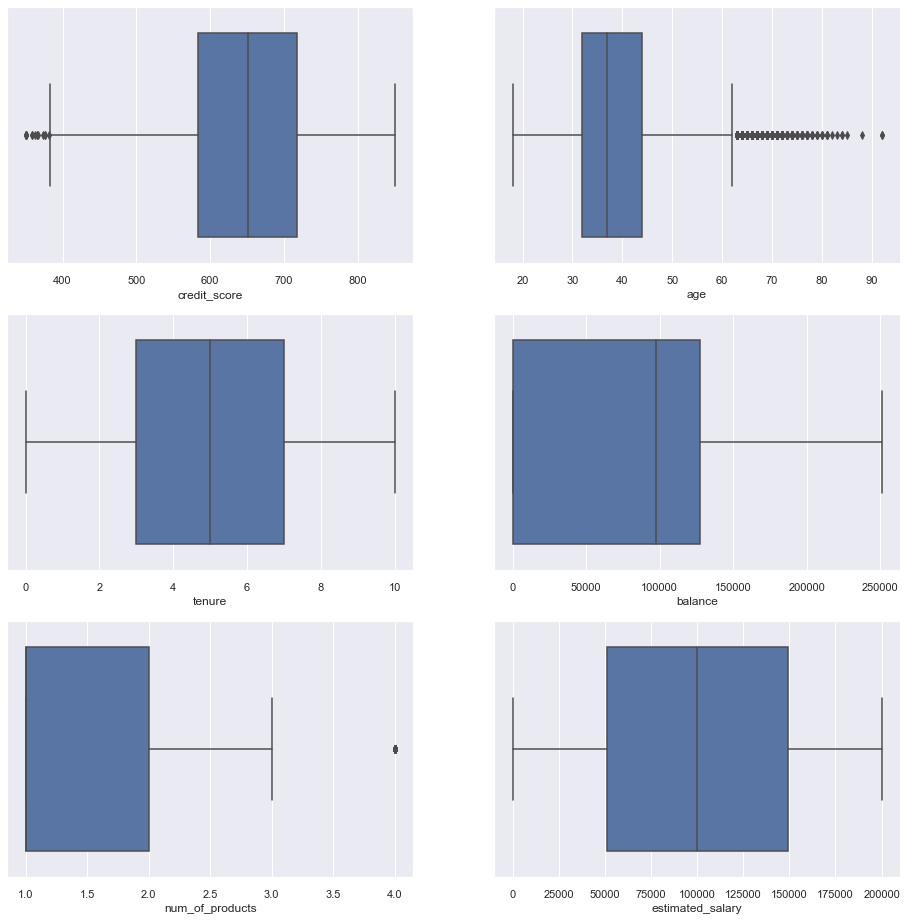

In [80]:
# set up figure size
plt.subplots(figsize=(16,16))

# credit_score boxplot
plt.subplot(3,2,1)
sns.boxplot(df5['credit_score'])

# age boxplot
plt.subplot(3,2,2)
sns.boxplot(df5['age'])

# tenure  boxplot
plt.subplot(3,2,3)
sns.boxplot(df5['tenure'])

# balance  boxplot
plt.subplot(3,2,4)
sns.boxplot(df5['balance'])

# num_of_products  boxplot
plt.subplot(3,2,5)
sns.boxplot(df5['num_of_products'])

# estimated_salary   boxplot
plt.subplot(3,2,6)
sns.boxplot(df5['estimated_salary'])


## 5.2 Rescaling

### 5.2.1 Standard Scaler

For features close to a normal distribution

In [81]:
ssc = StandardScaler()

In [82]:
# Credit Score

df5['credit_score'] = ssc.fit_transform(df5[['credit_score']].values )


### 5.2.2 MinMax Scaler

For features with low outliers influence.

In [83]:
mms = MinMaxScaler()

In [84]:
# Age
df5['age'] = mms.fit_transform(df5[['age']].values )

# Tenure
df5['tenure'] = mms.fit_transform(df5[['tenure']].values )

# Balance
df5['balance'] = mms.fit_transform(df5[['balance']].values )

# Num of Products
df5['num_of_products'] = mms.fit_transform(df5[['num_of_products']].values )

# Estimated Salary
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values )

## 5.3 Transformation

Apply One-Hot Encoding on geography and gender features due to their low cardinality.

In [85]:
# Gender (one hot encoding)

df5 = pd.get_dummies( df5, prefix=['gender'], columns=['gender'])

In [86]:
# Geography (one hot encoding)

df5 = pd.get_dummies( df5, prefix=['geography'], columns=['geography'])

## 

In [87]:
df5.head().T

,0,1,2,3,4
row_number,1,2,3,4,5
customer_id,15634602,15647311,15619304,15701354,15737888
surname,Hargrave,Hill,Onio,Boni,Mitchell
credit_score,-0.32622,-0.44004,-1.53679,0.50152,2.06388
age,0.32432,0.31081,0.32432,0.28378,0.33784
tenure,0.20000,0.10000,0.80000,0.10000,0.20000
balance,0.00000,0.33403,0.63636,0.00000,0.50025
num_of_products,0.00000,0.00000,0.66667,0.33333,0.00000
has_cr_card,1,0,1,0,1
is_active_member,1,1,0,0,1


In [88]:
num_attributes = df5.select_dtypes(include=['int64', 'float64'])

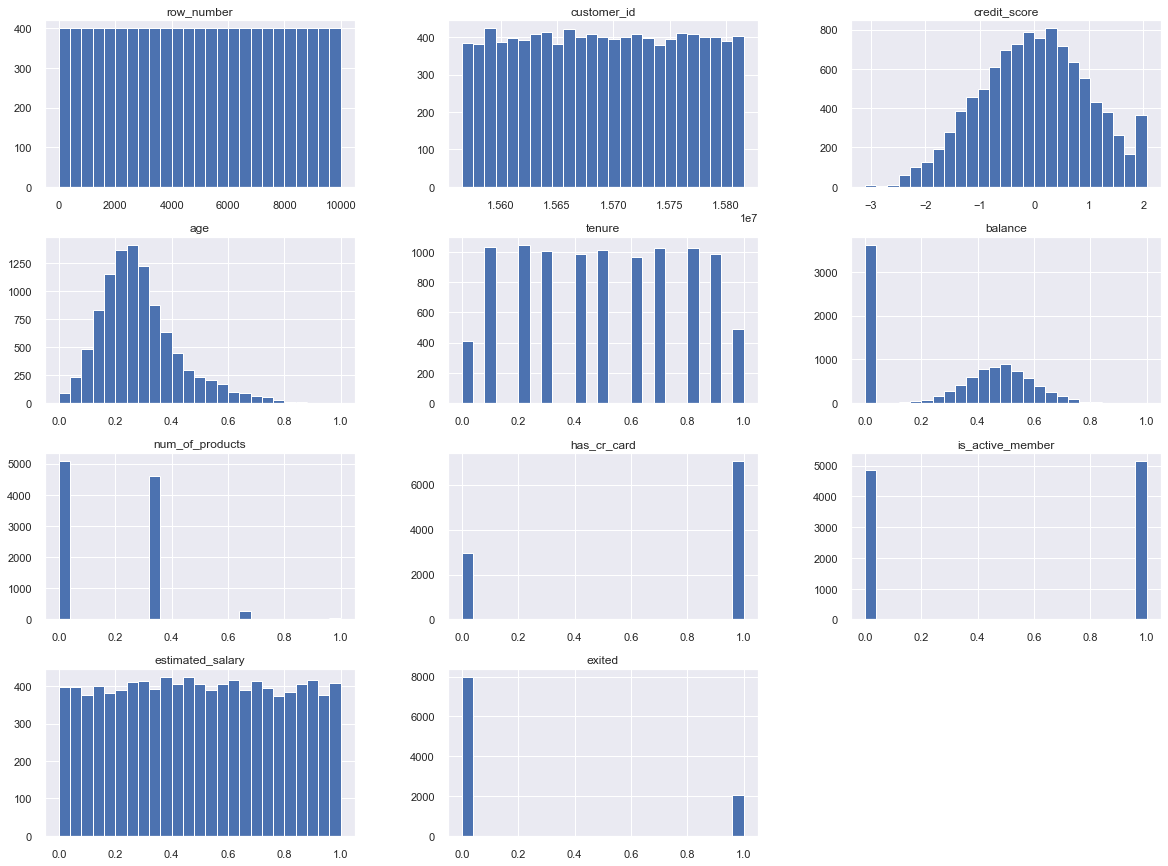

In [89]:
num_attributes.hist( bins=25, figsize=(20,15) );

# STEP 06 - FEATURE SELECTION

In [90]:
df6 = df5.copy()

In [91]:
# Remove unnecessary Columns

# Remove row_number, customer_id and surname columns. They will not be applied for the machine learning training.
df6 = df6.drop(['row_number', 'customer_id', 'surname'], axis=1)

## 6.1 Split Dataframe into training and test dataset

In [92]:
# checking 'Exited' feature proportion in dataset

df6['exited'].value_counts(normalize=True)

0   0.79630
1   0.20370
Name: exited, dtype: float64

In [93]:
# Apply stratified sampling in order to keep target variable proportion in the train and test sets

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(df6, df6['exited']):
    train_set = df6.loc[train_index]
    test_set = df6.loc[test_index]

In [94]:
# checking 'Exited' feature proportion in Training dataset

train_set['exited'].value_counts(normalize=True)

0   0.79625
1   0.20375
Name: exited, dtype: float64

In [95]:
# checking 'Exited' feature proportion in Testing dataset

test_set['exited'].value_counts(normalize=True)

0   0.79650
1   0.20350
Name: exited, dtype: float64

In [96]:
# save train_set

train_set.to_csv('data/train.csv', index=False)

In [97]:
# save test_set
test_set.to_csv('data/test.csv', index=False)

In [98]:
# Remove target variable from train set
X_train = train_set.drop('exited', axis=1)
# Remove target variable from test set
X_test = test_set.drop('exited', axis=1)

# target variable
y_train = train_set['exited'].copy()
y_test = test_set['exited'].copy()

In [99]:
X_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain
2151,1.06025,0.52703,0.70000,0.00000,0.00000,1,0,0.79739,0,1,1,0,0
8392,0.91539,0.18919,0.30000,0.40705,0.00000,1,0,0.31988,0,1,0,1,0
5006,1.08094,0.25676,0.00000,0.45383,0.33333,1,1,0.58698,1,0,0,1,0
4117,-0.92633,0.25676,0.50000,0.00000,0.33333,1,0,0.41545,0,1,1,0,0
7182,0.42909,0.41892,0.60000,0.44058,0.33333,0,1,0.53736,0,1,0,1,0


In [100]:
X_test.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain
5702,-0.67801,0.24324,0.70000,0.00000,0.33333,1,0,0.47140,0,1,1,0,0
3667,-1.29882,0.20270,0.40000,0.52222,0.33333,0,0,0.27533,0,1,0,1,0
1617,-0.96772,0.29730,0.40000,0.00000,0.33333,0,1,0.52716,1,0,0,0,1
5673,-0.11929,0.21622,0.50000,0.55558,0.33333,0,0,0.16971,0,1,0,0,1
4272,-0.10894,0.21622,0.30000,0.31019,0.00000,1,1,0.84275,1,0,0,0,1


In [101]:
y_train.head()

2151    1
8392    1
5006    0
4117    0
7182    0
Name: exited, dtype: int64

In [102]:
y_test.head()

5702    0
3667    0
1617    0
5673    0
4272    0
Name: exited, dtype: int64

## 6.2 Feature Selector

### 6.2.1 Random Forest Classifier

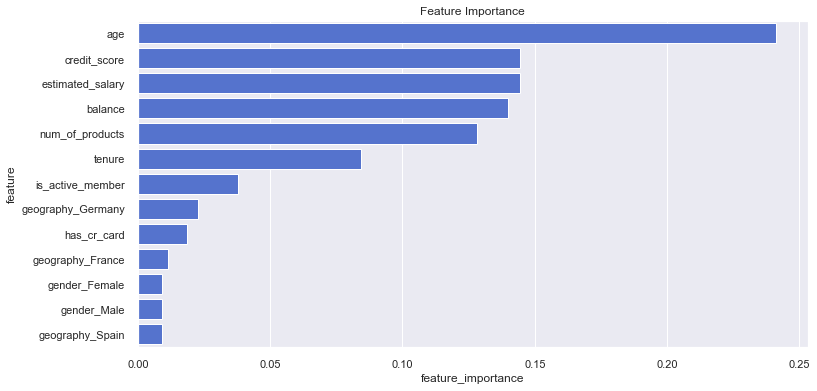

In [103]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

### 6.2.2 Boruta 

In [104]:
#  training and test dataset for Boruta
X_boruta = X_train.values
y_boruta = y_train.values.ravel()


In [105]:
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_boruta, y_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	8
Iteration:

In [106]:
cols_selected = boruta.support_.tolist()

#best features
cols_selected_boruta = X_train.iloc[: , cols_selected].columns.to_list()

#features not selected
cols_not_selected_boruta = list(np.setdiff1d( X_train.columns, cols_selected))

In [107]:
cols_selected_boruta

['age', 'balance', 'num_of_products', 'estimated_salary']

### 6.2.3 Final Selection

In [108]:
# Based on EDA and both feature selectors:

cols_selected = ['age', 'balance', 'num_of_products', 'estimated_salary', 'credit_score', 
                 'is_active_member', 'geography_Germany','geography_France','geography_Spain']

# STEP 07 - Machine Learning Modelling

In [109]:
# train data with selected features of Feature Selection
x_train = X_train[cols_selected]

# test data with selected features of Feature Selection
x_test = X_test[cols_selected]

In [110]:
x_train.head()

,age,balance,num_of_products,estimated_salary,credit_score,is_active_member,geography_Germany,geography_France,geography_Spain
2151,0.52703,0.00000,0.00000,0.79739,1.06025,0,0,1,0
8392,0.18919,0.40705,0.00000,0.31988,0.91539,0,1,0,0
5006,0.25676,0.45383,0.33333,0.58698,1.08094,1,1,0,0
4117,0.25676,0.00000,0.33333,0.41545,-0.92633,0,0,1,0
7182,0.41892,0.44058,0.33333,0.53736,0.42909,1,1,0,0


In [111]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 2151 to 6206
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                8000 non-null   float64
 1   balance            8000 non-null   float64
 2   num_of_products    8000 non-null   float64
 3   estimated_salary   8000 non-null   float64
 4   credit_score       8000 non-null   float64
 5   is_active_member   8000 non-null   int64  
 6   geography_Germany  8000 non-null   uint8  
 7   geography_France   8000 non-null   uint8  
 8   geography_Spain    8000 non-null   uint8  
dtypes: float64(5), int64(1), uint8(3)
memory usage: 460.9 KB


## 7.1. Balancing Data for Training

In [112]:
# set the resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# resample the dataset
x_balanced, y_balanced = resampler.fit_resample(x_train, y_train)

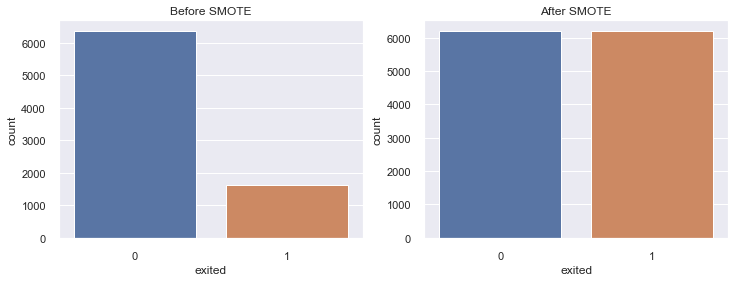

In [113]:
# plots before and after SMOTETomek
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=y_balanced)
plt.title("After SMOTE")

plt.show()

## 7.2 Logistic Regression

### 7.2.1. Imbalanced Data

In [114]:
# model definition
lr_model = LogisticRegression()

# model training
lr_model.fit(x_train, y_train)

# model prediction
y_pred_lr = lr_model.predict(x_test)

In [115]:
# imprimir relatório de classificação 
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_lr, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.8196    0.9699    0.8884      1593
           1     0.5826    0.1646    0.2567       407

    accuracy                         0.8060      2000
   macro avg     0.7011    0.5672    0.5726      2000
weighted avg     0.7714    0.8060    0.7599      2000



### 7.2.2. Imbalanced Data - Cross Validation

In [116]:
# model performance with performance function
lr_model_performance = performance(lr_model, x_train, y_train)
lr_model_performance

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.81388,0.64581,0.19325,0.29737,0.58297,0.27942


In [117]:
# model prediction
y_pred_lr_cv = cross_val_predict(lr_model, x_train, y_train, cv=10)

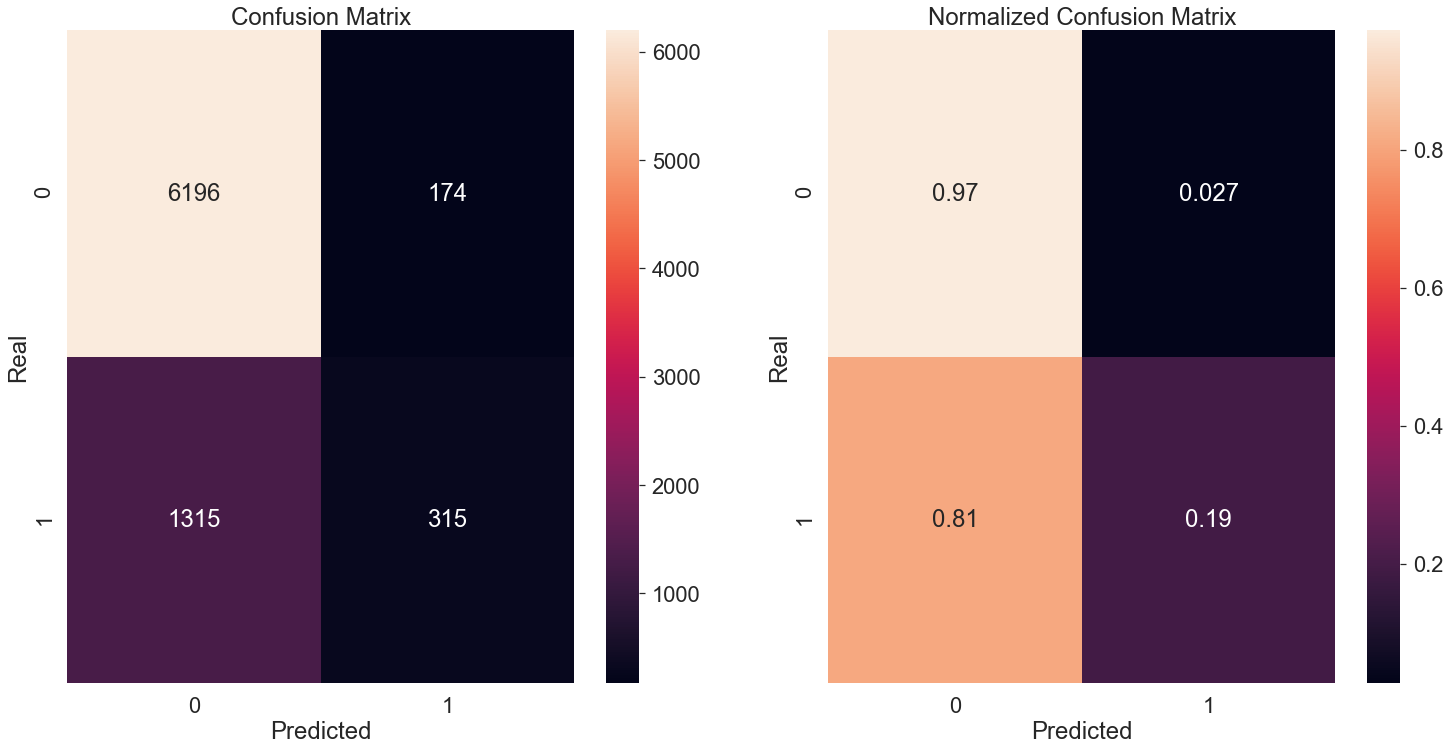

In [210]:
plt.subplot(1,2,1)

# confusion matrix
lr_cm_1 = confusion_matrix(y_train, y_pred_lr_cv)
# confusion matrix heatmap
sns.heatmap(lr_cm_1, annot=True, fmt='d').set_title('Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);

plt.subplot(1,2,2)

# confusion matrix
lr_cm_2 = confusion_matrix(y_train, y_pred_lr_cv, normalize='true')
# confusion matrix heatmap
sns.heatmap(lr_cm_2, annot=True).set_title('Normalized Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);

### 7.2.3. Balanced Data

In [119]:
# model definition
lr_model = LogisticRegression()

# model training
lr_model.fit(x_balanced, y_balanced)

# model prediction
y_pred_lr_b = lr_model.predict(x_test)

In [120]:
# imprimir relatório de classificação 
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_lr_b, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9010    0.7200    0.8004      1593
           1     0.3865    0.6904    0.4956       407

    accuracy                         0.7140      2000
   macro avg     0.6438    0.7052    0.6480      2000
weighted avg     0.7963    0.7140    0.7384      2000



#### 7.2.3.1 Balanced Data - Cross Validation

In [121]:
# model performance with performance function
lr_model_performance = performance(lr_model, x_balanced, y_balanced)
lr_model_performance

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.71129,0.71862,0.69463,0.70630,0.71129,0.42294


In [122]:
# model prediction
y_pred_lr_cv_b = cross_val_predict(lr_model, x_balanced, y_balanced, cv=10)

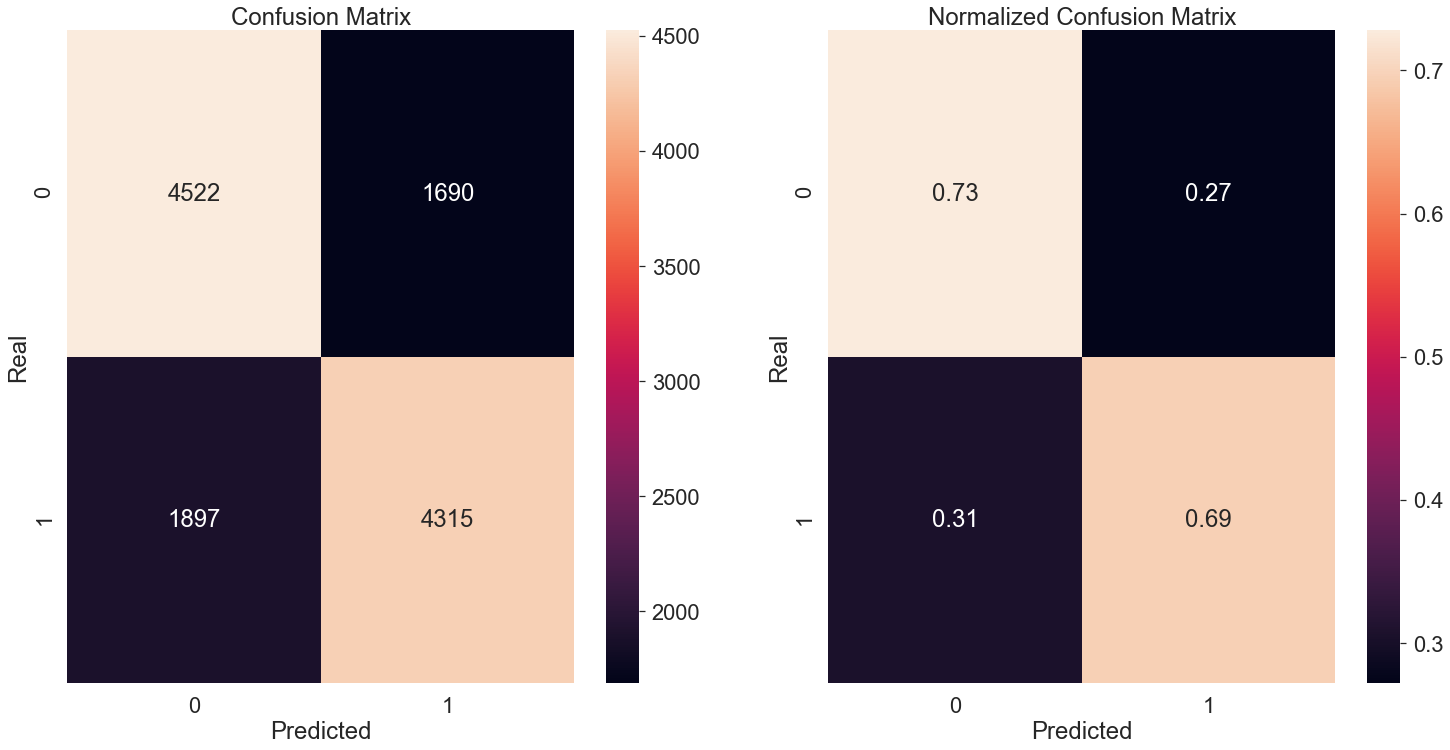

In [208]:
plt.subplot(1,2,1)

# confusion matrix
lr_cm_1 = confusion_matrix(y_balanced, y_pred_lr_cv_b)
# confusion matrix heatmap
sns.heatmap(lr_cm_1, annot=True, fmt='d').set_title('Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);

plt.subplot(1,2,2)

# confusion matrix
lr_cm_2 = confusion_matrix(y_balanced, y_pred_lr_cv_b, normalize='true')
# confusion matrix heatmap
sns.heatmap(lr_cm_2, annot=True).set_title('Normalized Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);

### 7.3. Decision Tree

### 7.3.1 Imbalanced Data

In [125]:
# model definition
dt_model = DecisionTreeClassifier(random_state=1986, criterion='gini', max_depth=3)

# model training
dt_model.fit(x_train, y_train)

# model prediction
y_pred_dt = dt_model.predict(x_test)


In [127]:
# imprimir relatório de classificação 
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_dt, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.8712    0.8575    0.8643      1593
           1     0.4745    0.5037    0.4887       407

    accuracy                         0.7855      2000
   macro avg     0.6729    0.6806    0.6765      2000
weighted avg     0.7905    0.7855    0.7878      2000



### 7.3.2 Balanced Data

In [160]:
# model definition
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)

# model training
dt_model.fit(x_balanced, y_balanced)

# model prediction
y_pred_dt_b = dt_model.predict(x_test)

#### 7.3.2.1 Balanced Data - Cross Validation

In [161]:
# model performance with performance function
dt_model_performance = performance(dt_model, x_balanced, y_balanced)
dt_model_performance

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.80104,0.80318,0.79687,0.79964,0.80104,0.60259


In [165]:
# model prediction
y_pred_dt_cv_b = cross_val_predict(dt_model, x_balanced, y_balanced, cv=10)

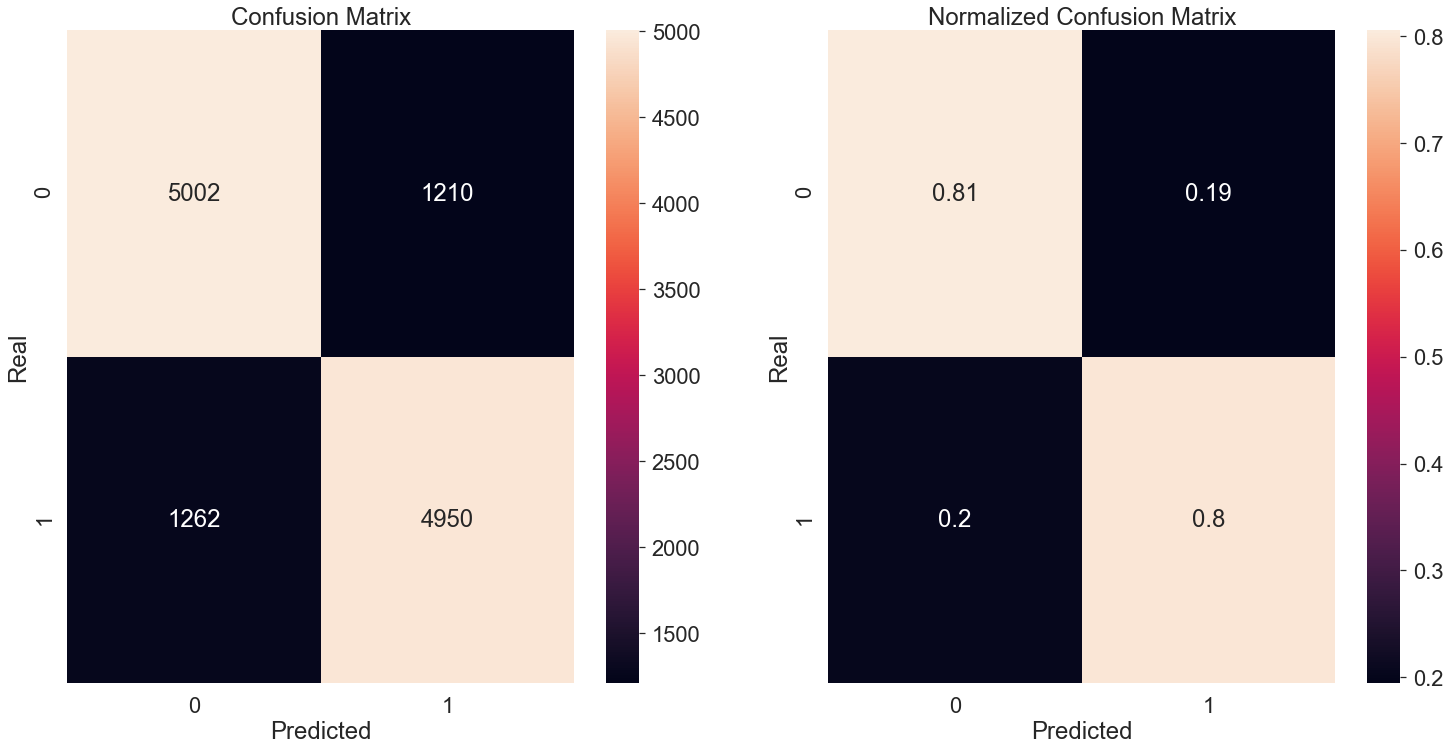

In [207]:
plt.subplot(1,2,1)

# confusion matrix
dt_cm_1 = confusion_matrix(y_balanced, y_pred_dt_cv_b)
# confusion matrix heatmap
sns.heatmap(dt_cm_1, annot=True, fmt='d').set_title('Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);

plt.subplot(1,2,2)

# confusion matrix
dt_cm_2 = confusion_matrix(y_balanced, y_pred_dt_cv_b, normalize='true')
# confusion matrix heatmap
sns.heatmap(dt_cm_2, annot=True).set_title('Normalized Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);

## 7.4 Random Forest Classifier

In [173]:
# model definition
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

# model training
rf_model.fit(x_train, y_train)


### 7.4.1 Cross Validation

In [175]:
# model prediction
y_pred_rf_cv_b = cross_val_predict(rf_model, x_balanced, y_balanced, cv=10)

In [179]:
# model performance with performance function
rf_model_performance = performance(rf_model, x_balanced, y_balanced)
rf_model_performance


,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.89948,0.89155,0.90893,0.89916,0.89949,0.80084


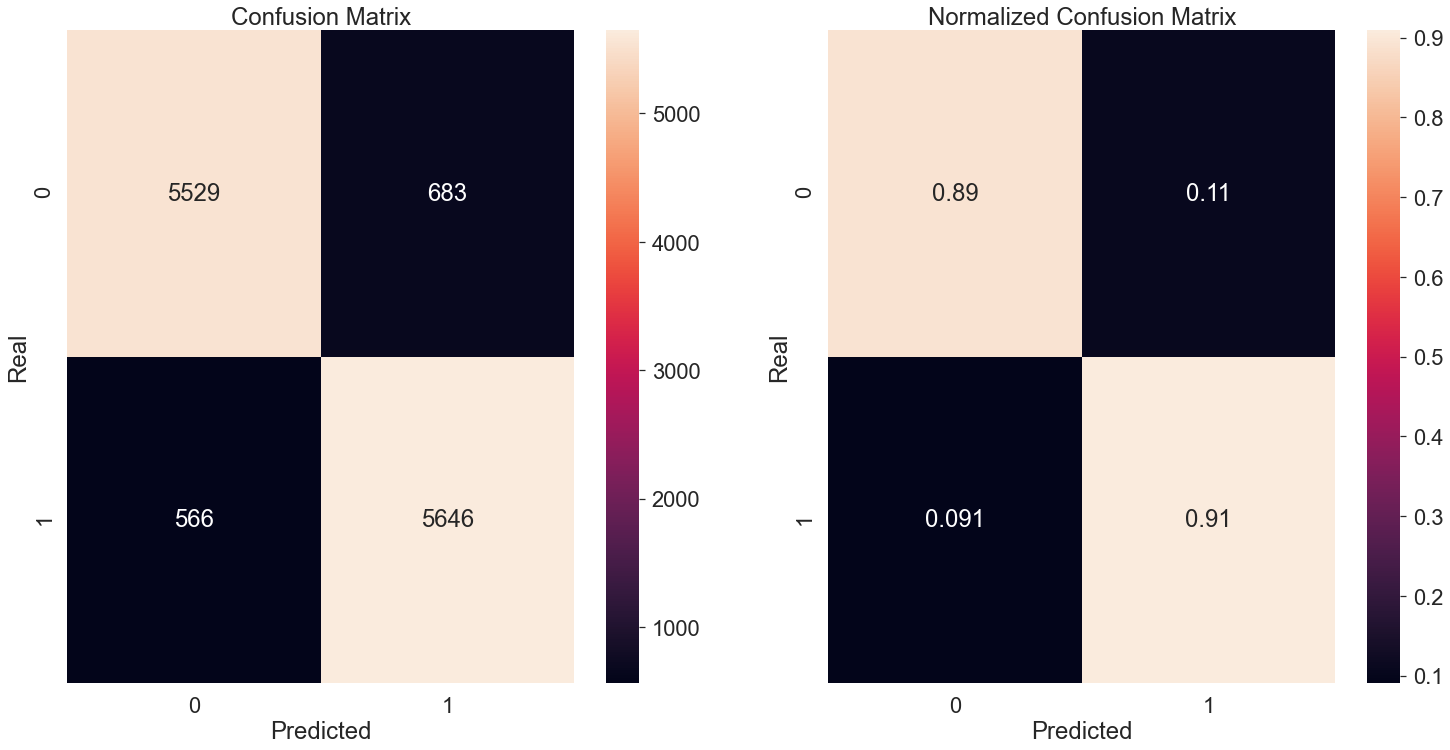

In [206]:
plt.subplot(1,2,1)

# confusion matrix
rf_cm_1 = confusion_matrix(y_balanced, y_pred_rf_cv_b)
# confusion matrix heatmap
sns.heatmap(rf_cm_1, annot=True, fmt='d').set_title('Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);

plt.subplot(1,2,2)

# confusion matrix
rf_cm_2 = confusion_matrix(y_balanced, y_pred_rf_cv_b, normalize='true')
# confusion matrix heatmap
sns.heatmap(rf_cm_2, annot=True).set_title('Normalized Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);

## 7.5 XGBoost Classifier

In [192]:
# model definition
xgb_model = XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss').fit(x_balanced, y_balanced)


### 7.5.1 Cross Validation

In [194]:
#model prediction

y_pred_xgb_cv_b = cross_val_predict(xgb_model, x_balanced, y_balanced, cv=10)

In [193]:
# model performance with performance function
xgb_model_performance = performance(xgb_model, x_balanced, y_balanced)
xgb_model_performance

,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc_score,test_mcc
0,0.89949,0.91779,0.87518,0.88763,0.89952,0.80877


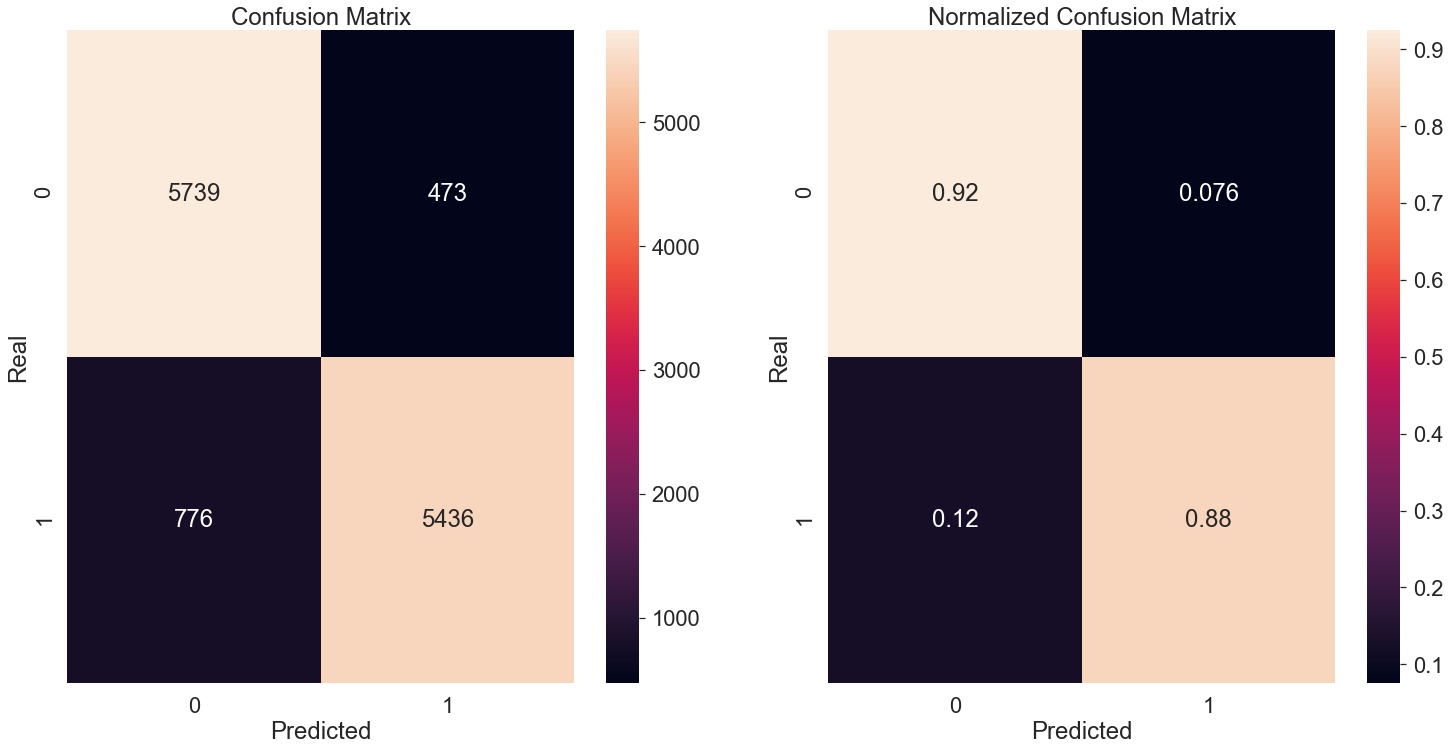

In [205]:
plt.subplot(1,2,1)

# confusion matrix
xgb_cm_1 = confusion_matrix(y_balanced, y_pred_xgb_cv_b)
# confusion matrix heatmap
sns.heatmap(xgb_cm_1, annot=True, fmt='d').set_title('Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);

plt.subplot(1,2,2)

# confusion matrix
xgb_cm_2 = confusion_matrix(y_balanced, y_pred_xgb_cv_b, normalize='true')
# confusion matrix heatmap
sns.heatmap(xgb_cm_2, annot=True).set_title('Normalized Confusion Matrix');
plt.xlabel('Predicted');
plt.ylabel('Real');
sns.set(font_scale=2);